In [1]:

import pandas as pd 
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import StratifiedKFold,  GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import gc



# Базовая модель

WAU = 0.033261511181721264; UpLift at 30% 0.03346924284858077


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


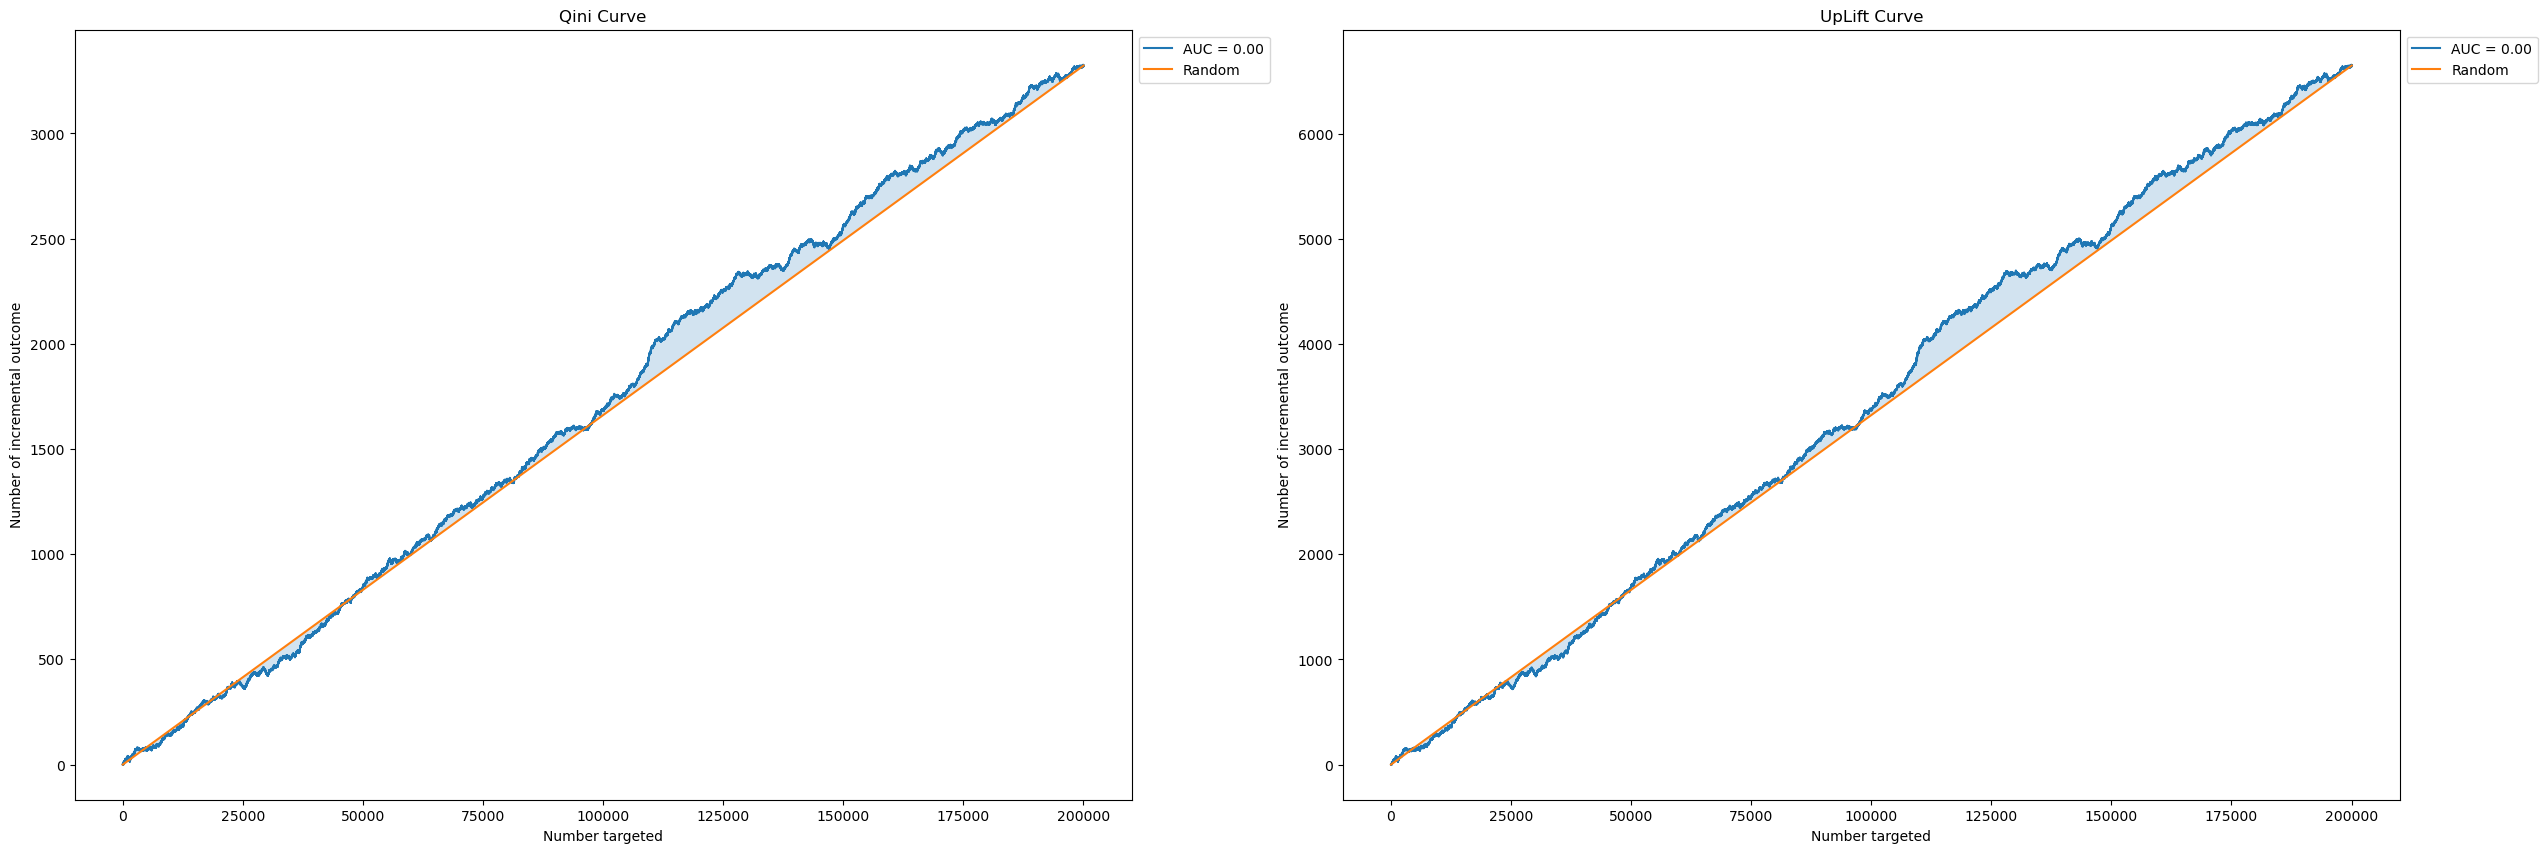

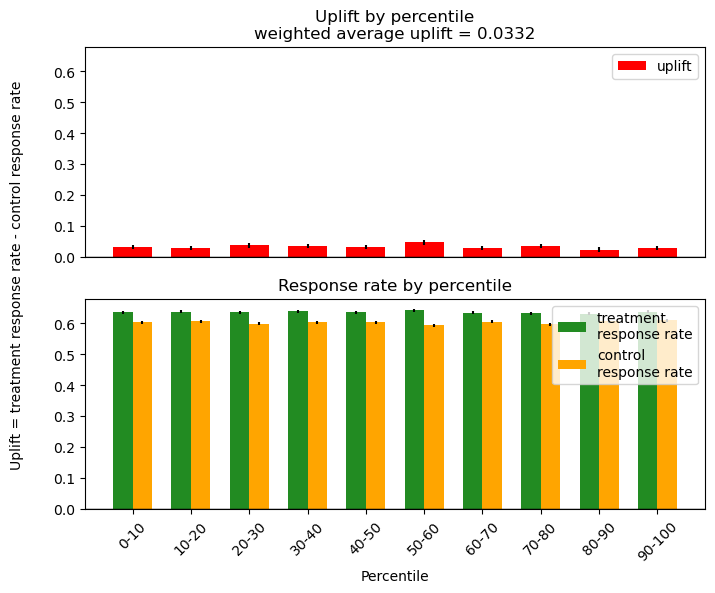

In [2]:


df= pd.read_csv(r'X5_clients_data_train.csv' , sep = ';')
df.describe()
med = df.age.median()
df.age = df.age.apply(lambda x: x if((x >= 16) and (x <= 90)) else med)
df.age = df.age.fillna(med)
df.Mean_diffs = df.Mean_diffs.fillna(df.Mean_diffs.median()) 
df = df.fillna(0)
df.describe()

df = df.drop(['MeanItemCost', 'client_id'
                , 'Mean_TOP_1_BRAND'
                ,	'Mean_TOP_2_BRAND'
                ,	'Mean_TOP_3_BRAND'
                ,	'Mean_TOP_4_BRAND',
                	'Mean_TOP_5_BRAND',
                    'Mean_TOP_1_SEG',
                    'Mean_TOP_2_SEG',
                    'Mean_TOP_3_SEG',
                    'Mean_TOP_4_SEG',
                    'Mean_TOP_5_SEG',
                    'first_order_date'	], axis = 1)
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
treat = df.treatment_flg.values
y = df.iloc[:, -1].values
del df
gc.collect()

from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


y_pred = np.random.uniform(-1, 1, len(treat)).tolist()
gc.collect()
wau = weighted_average_uplift(y_true=y , uplift=y_pred,
                        treatment=treat)
uplift_overall = uplift_at_k(y_true=y , uplift=y_pred,
                        treatment=treat, strategy='by_group', k=0.3)

print(f'WAU = {wau}; UpLift at 30% {uplift_overall}')
fig, ax = plt.subplots(1, 2, figsize = (30, 10))
ax[0].set_title('Qini Curve')
ax[1].set_title('UpLift Curve')
plot_qini_curve(y_true=y , uplift=y_pred,
                        treatment=treat, ax = ax[0], perfect=False)
gc.collect()
plot_uplift_curve(y_true=y , uplift=y_pred,
                        treatment=treat, ax = ax[1], perfect=False)
gc.collect()
gc.collect()
gc.collect()
plt.savefig(f"Plots/Base model Split.png")

plot_uplift_by_percentile(y_true=y , uplift=y_pred,
                        treatment=treat, kind='bar')
plt.savefig(f"Plots/Base model Procentile.png")






# Метод одной модели

In [3]:

df= pd.read_csv(r'X5_clients_data_train.csv', sep = ';')
display(df.describe())
display(df.dtypes)

,regular_points_received,express_points_received,regular_points_spent,express_points_spent,regular_balance,express_balance,Total_Amount,Amount_BonusDiscount_purchs,BonusDiscount,MeanChk,...,Part_alc_purchs,PArt_CTM_purchs,cnt_alc_purchs,cnt_CTM_purchs,Mean_diffs,age,LoveBonuses,Gender,treatment_flg,target
count,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,...,200039.000000,200039.000000,200039.000000,200039.000000,196219.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000
mean,78.022883,0.796720,73.397088,6.454331,4.625795,-5.657612,8597.521955,585.270043,0.112710,495.783222,...,0.086030,0.539959,1.657737,10.049480,8.900076,46.417329,0.552672,-0.296547,0.499808,0.619889
std,98.582251,7.655577,132.516680,16.306043,89.682951,17.307266,8914.597077,1201.394707,0.141952,374.548483,...,0.167211,0.268285,4.396483,9.645702,10.557729,49.532475,0.894372,0.737329,0.500001,0.485415
min,0.000000,0.000000,0.000000,0.000000,-4919.800000,-210.000000,1.040000,0.000000,0.000000,1.040000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-7491.000000,0.000000,-1.000000,0.000000,0.000000
25%,23.300000,0.000000,0.000000,0.000000,-12.200000,0.000000,3147.615000,0.000000,0.000000,261.290000,...,0.000000,0.333333,0.000000,4.000000,3.000000,34.000000,0.000000,-1.000000,0.000000,0.000000
50%,49.200000,0.000000,27.000000,0.000000,9.200000,0.000000,6102.440000,183.000000,0.059908,393.999846,...,0.000000,0.538462,0.000000,7.000000,6.000000,45.000000,0.000000,0.000000,0.000000,1.000000
75%,96.700000,0.000000,98.000000,0.000000,33.100000,0.000000,11094.185000,698.000000,0.173150,608.740000,...,0.100000,0.750000,2.000000,14.000000,10.000000,59.000000,2.000000,0.000000,1.000000,1.000000
max,8635.000000,310.000000,10131.000000,330.000000,1553.600000,300.000000,504490.380000,78483.850000,0.500000,7694.000000,...,1.000000,1.000000,161.000000,246.000000,113.000000,1852.000000,2.000000,1.000000,1.000000,1.000000


client_id                       object
regular_points_received        float64
express_points_received        float64
regular_points_spent           float64
express_points_spent           float64
regular_balance                float64
express_balance                float64
Total_Amount                   float64
Amount_BonusDiscount_purchs    float64
BonusDiscount                  float64
MeanChk                        float64
avg_regular_points_received    float64
avg_express_points_received    float64
avg_regular_points_spent       float64
avg_express_points_spent       float64
MeanItemCost                   float64
Chks                             int64
Part_BonusDiscount_purchs      float64
cnt_BonusDiscount_purchs         int64
last_chk_ago                     int64
Mean_TOP_1_BRAND               float64
Mean_TOP_2_BRAND               float64
Mean_TOP_3_BRAND               float64
Mean_TOP_4_BRAND               float64
Mean_TOP_5_BRAND               float64
Mean_TOP_1_SEG           

In [4]:
med = df.age.median()
df.age = df.age.apply(lambda x: x if((x >= 16) and (x <= 90)) else med)
df.age = df.age.fillna(med)
df.Mean_diffs = df.Mean_diffs.fillna(df.Mean_diffs.median()) 
df = df.fillna(0)

In [5]:
df.describe()

,regular_points_received,express_points_received,regular_points_spent,express_points_spent,regular_balance,express_balance,Total_Amount,Amount_BonusDiscount_purchs,BonusDiscount,MeanChk,...,Part_alc_purchs,PArt_CTM_purchs,cnt_alc_purchs,cnt_CTM_purchs,Mean_diffs,age,LoveBonuses,Gender,treatment_flg,target
count,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,...,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000
mean,78.022883,0.796720,73.397088,6.454331,4.625795,-5.657612,8597.521955,585.270043,0.112710,495.783222,...,0.086030,0.539959,1.657737,10.049480,8.844695,46.509161,0.552672,-0.296547,0.499808,0.619889
std,98.582251,7.655577,132.516680,16.306043,89.682951,17.307266,8914.597077,1201.394707,0.141952,374.548483,...,0.167211,0.268285,4.396483,9.645702,10.463966,15.715009,0.894372,0.737329,0.500001,0.485415
min,0.000000,0.000000,0.000000,0.000000,-4919.800000,-210.000000,1.040000,0.000000,0.000000,1.040000,...,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,0.000000,-1.000000,0.000000,0.000000
25%,23.300000,0.000000,0.000000,0.000000,-12.200000,0.000000,3147.615000,0.000000,0.000000,261.290000,...,0.000000,0.333333,0.000000,4.000000,3.000000,34.000000,0.000000,-1.000000,0.000000,0.000000
50%,49.200000,0.000000,27.000000,0.000000,9.200000,0.000000,6102.440000,183.000000,0.059908,393.999846,...,0.000000,0.538462,0.000000,7.000000,6.000000,45.000000,0.000000,0.000000,0.000000,1.000000
75%,96.700000,0.000000,98.000000,0.000000,33.100000,0.000000,11094.185000,698.000000,0.173150,608.740000,...,0.100000,0.750000,2.000000,14.000000,10.000000,59.000000,2.000000,0.000000,1.000000,1.000000
max,8635.000000,310.000000,10131.000000,330.000000,1553.600000,300.000000,504490.380000,78483.850000,0.500000,7694.000000,...,1.000000,1.000000,161.000000,246.000000,113.000000,90.000000,2.000000,1.000000,1.000000,1.000000


In [6]:
df = df.drop(['MeanItemCost', 'client_id'
                , 'Mean_TOP_1_BRAND'
                ,	'Mean_TOP_2_BRAND'
                ,	'Mean_TOP_3_BRAND'
                ,	'Mean_TOP_4_BRAND',
                	'Mean_TOP_5_BRAND',
                    'Mean_TOP_1_SEG',
                    'Mean_TOP_2_SEG',
                    'Mean_TOP_3_SEG',
                    'Mean_TOP_4_SEG',
                    'Mean_TOP_5_SEG',
                    'first_order_date'	], axis = 1)

In [7]:
df.iloc[:, 0:-1].head()

,regular_points_received,express_points_received,regular_points_spent,express_points_spent,regular_balance,express_balance,Total_Amount,Amount_BonusDiscount_purchs,BonusDiscount,MeanChk,...,Mean_CTM,Part_alc_purchs,PArt_CTM_purchs,cnt_alc_purchs,cnt_CTM_purchs,Mean_diffs,age,LoveBonuses,Gender,treatment_flg
0,17.1,0.0,0.0,0.0,17.1,0.0,2950.17,0.00,0.000000,268.197273,...,0.000000,0.0,0.000000,0,0,10.0,26.0,0,-1,0
1,21.2,0.0,6.0,0.0,15.2,0.0,2334.64,190.75,0.030496,466.928000,...,0.112420,0.0,0.800000,0,4,19.0,35.0,0,-1,1
2,26.2,0.0,0.0,0.0,26.2,0.0,4534.55,0.00,0.000000,251.919444,...,0.360417,0.0,0.444444,0,8,6.0,23.0,2,0,1
3,13.7,0.0,0.0,0.0,13.7,0.0,2359.99,0.00,0.000000,181.537692,...,0.321429,0.0,0.538462,0,7,5.0,69.0,0,-1,1
4,90.4,0.0,149.0,0.0,-58.6,0.0,8259.32,1014.49,0.128063,485.842353,...,0.203293,0.0,0.647059,0,11,6.0,23.0,0,-1,1


In [8]:
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
treat = df.treatment_flg.values
X = df.iloc[:, 0:-1].values
X = (X - X.mean()) / X.std()
y = df.iloc[:, -1].values
del df
gc.collect()

9356

In [9]:
t_0 = np.argwhere(treat == 0)
t_1 = np.argwhere(treat == 1)
y_c = y[t_0]
len(y_c[y_c == 1]) / len(y_c)

0.6032800975434248

In [10]:
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt



Split 1; WAU = 0.03310461997824927; UpLift at 30% 0.0386833957145285


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 2; WAU = 0.03251776774321422; UpLift at 30% 0.029628169995142506


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 3; WAU = 0.029692423820155446; UpLift at 30% 0.026324190561810346


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 4; WAU = 0.03515098540062246; UpLift at 30% 0.037233207277446945


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 5; WAU = 0.035321029286935375; UpLift at 30% 0.027732368376615302


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


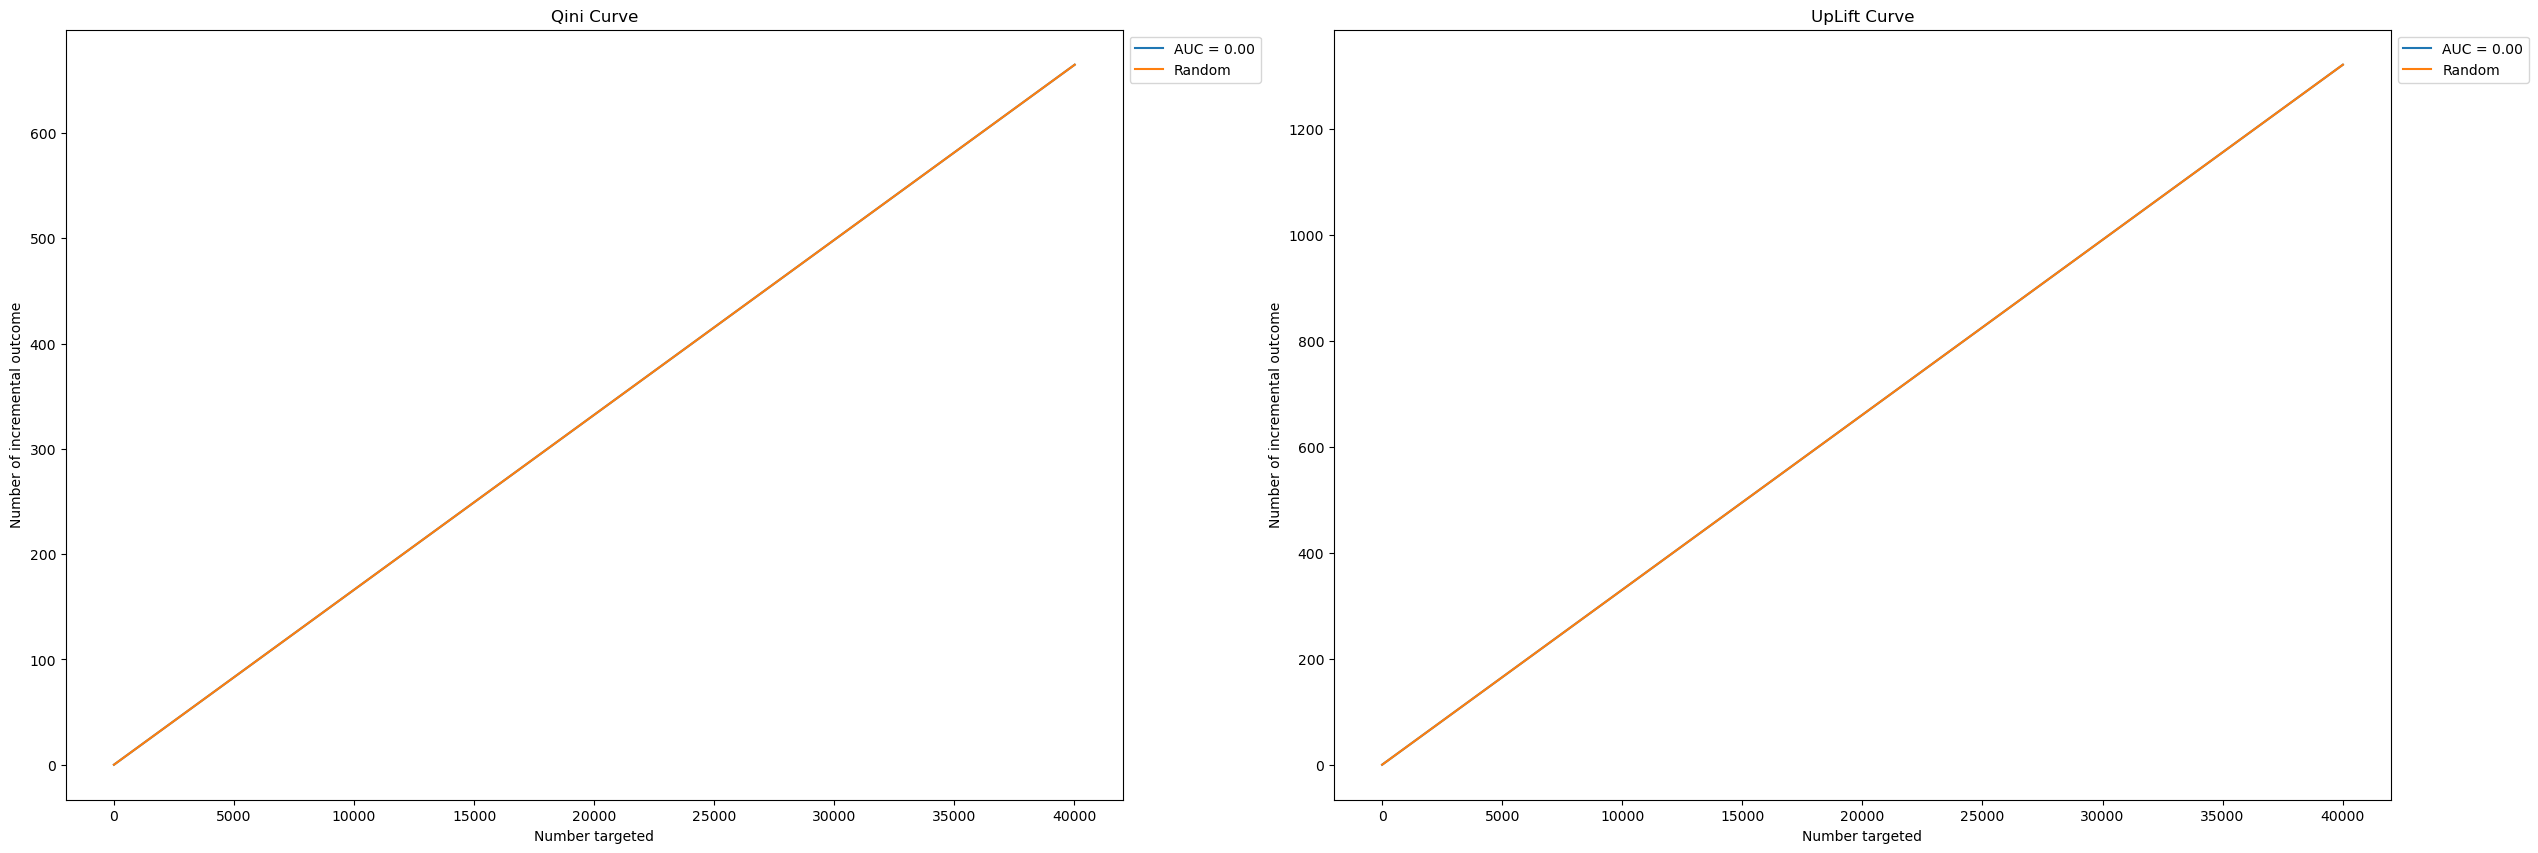

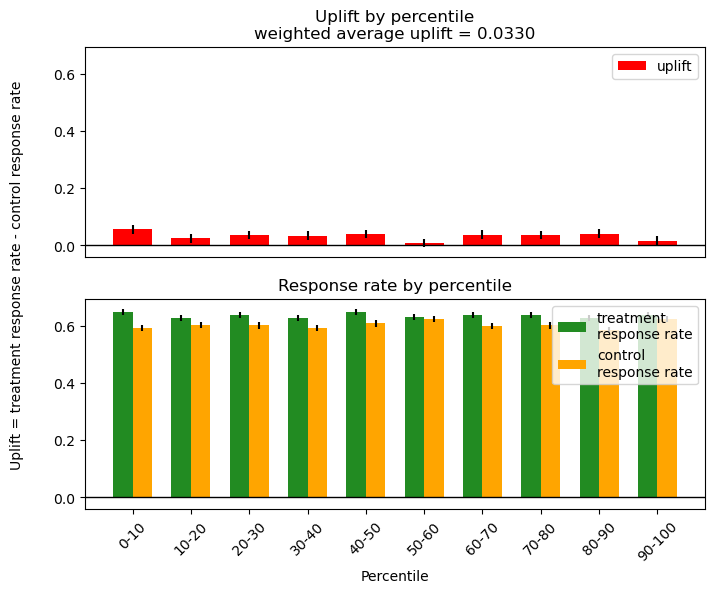

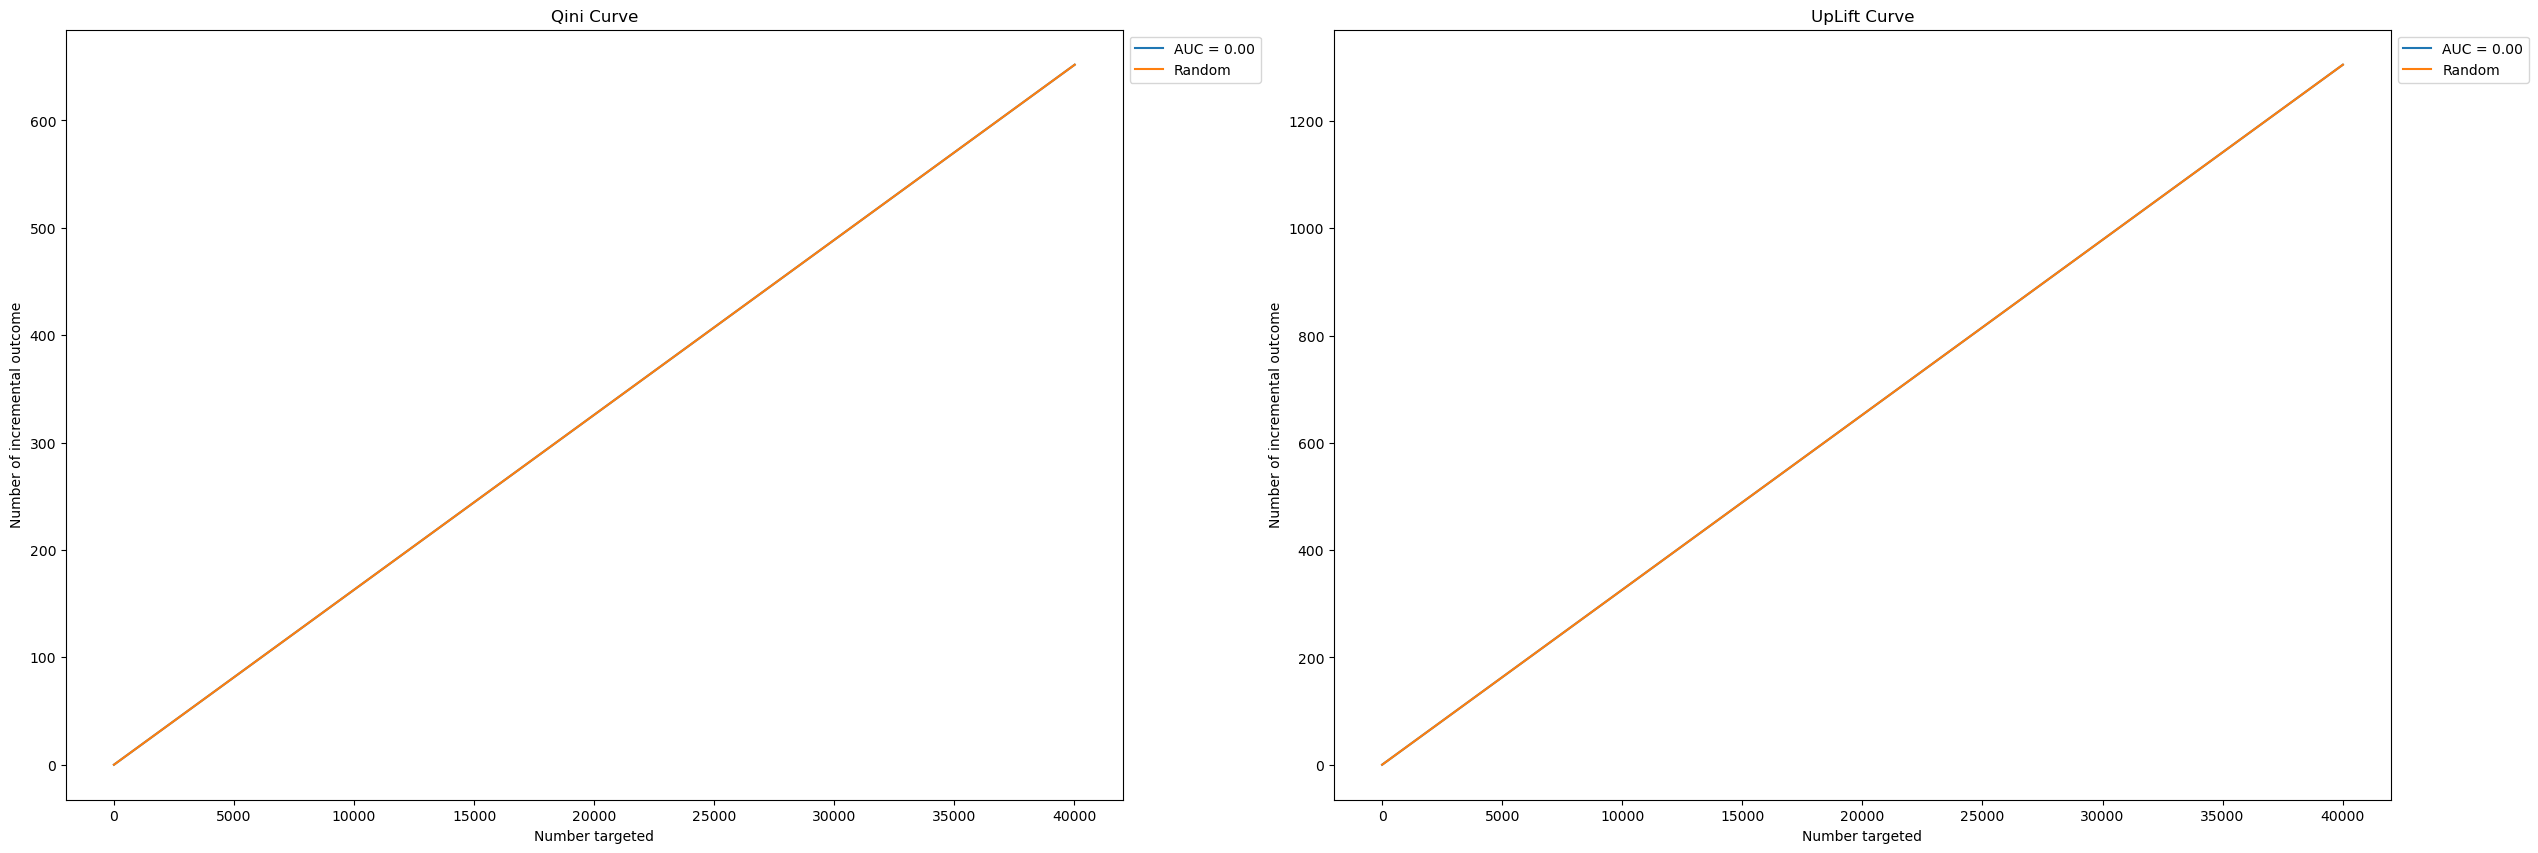

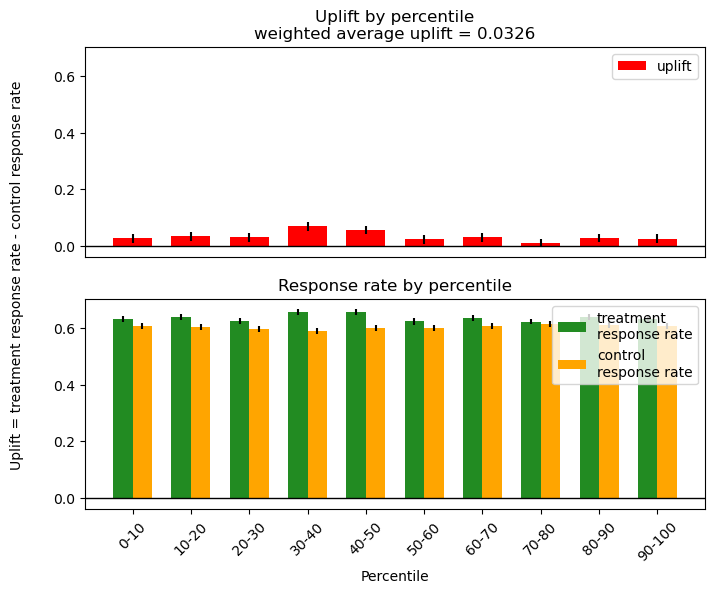

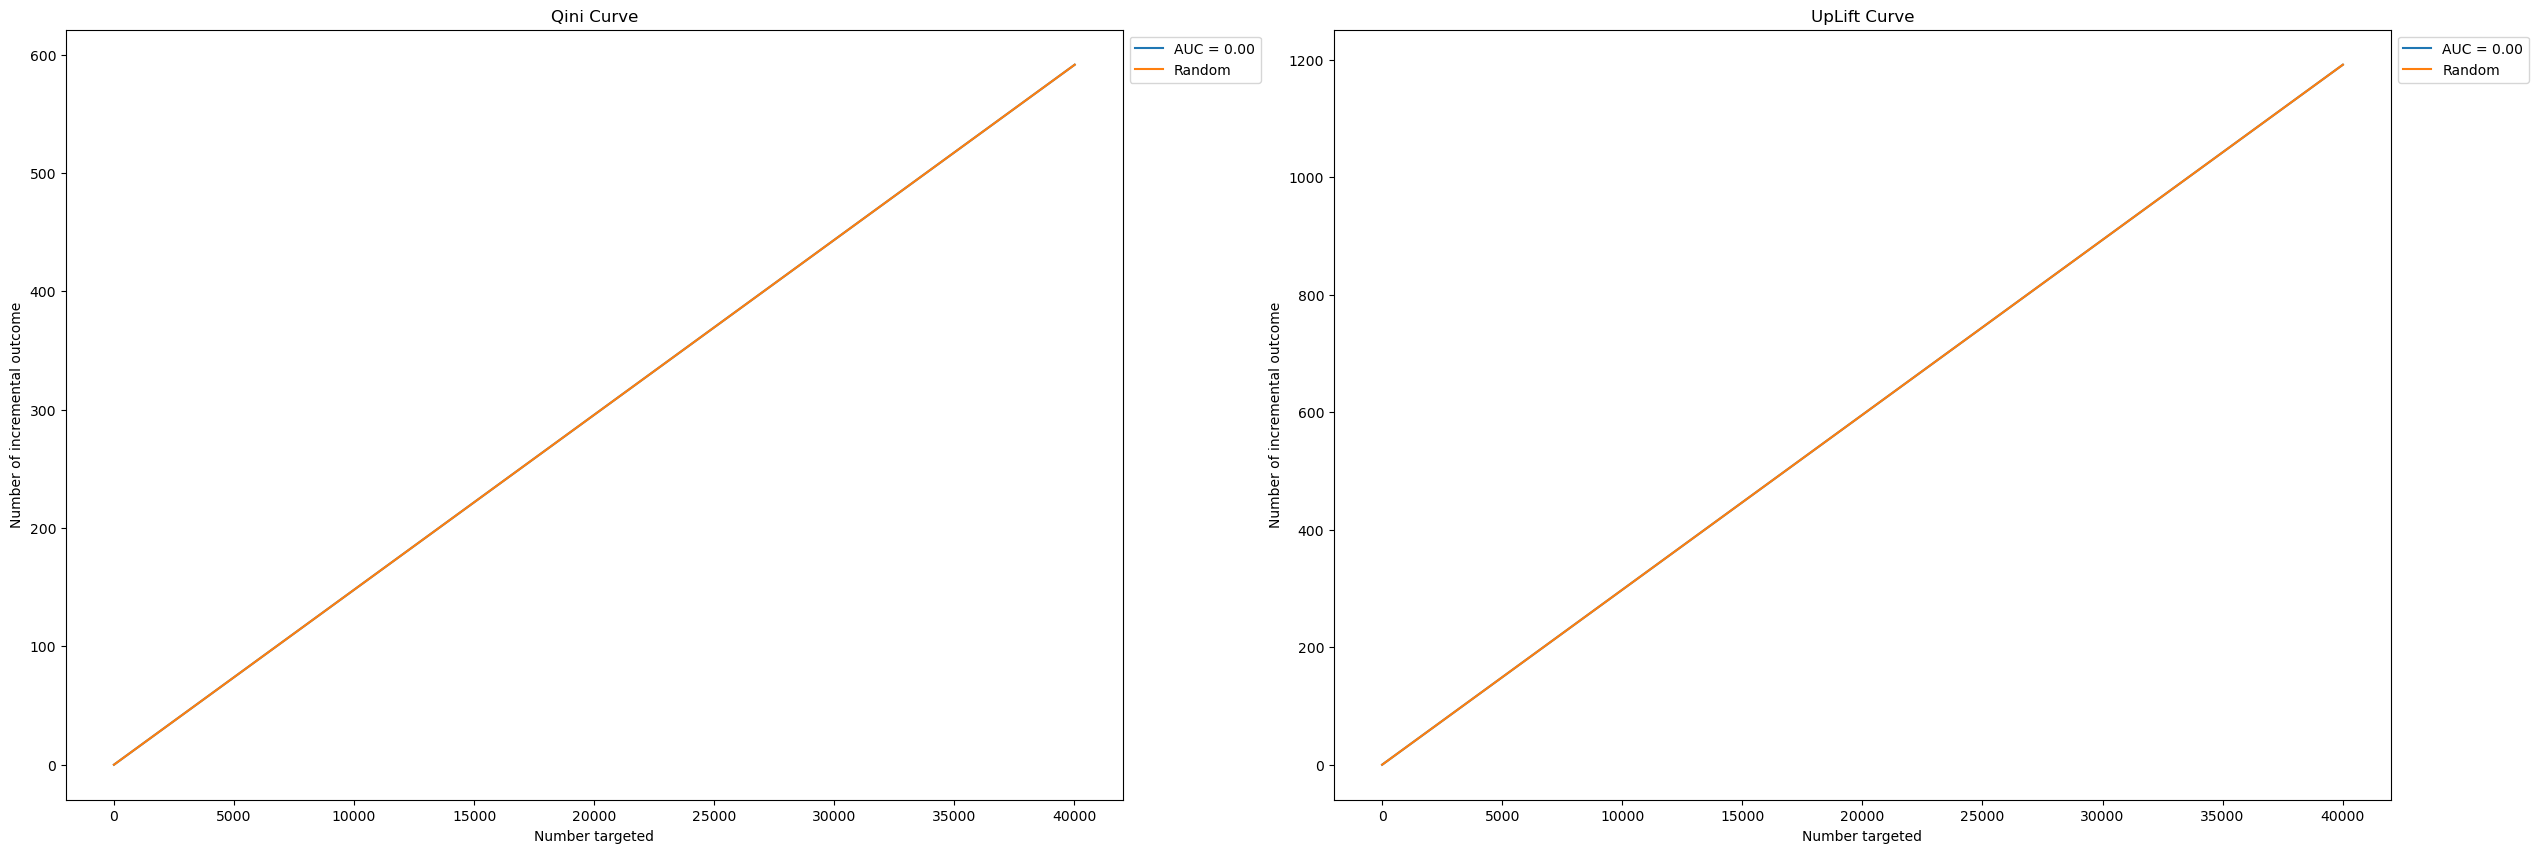

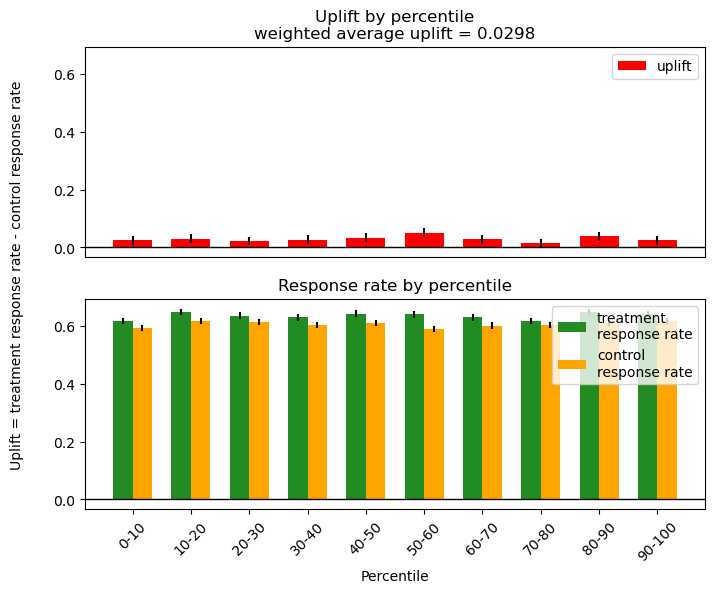

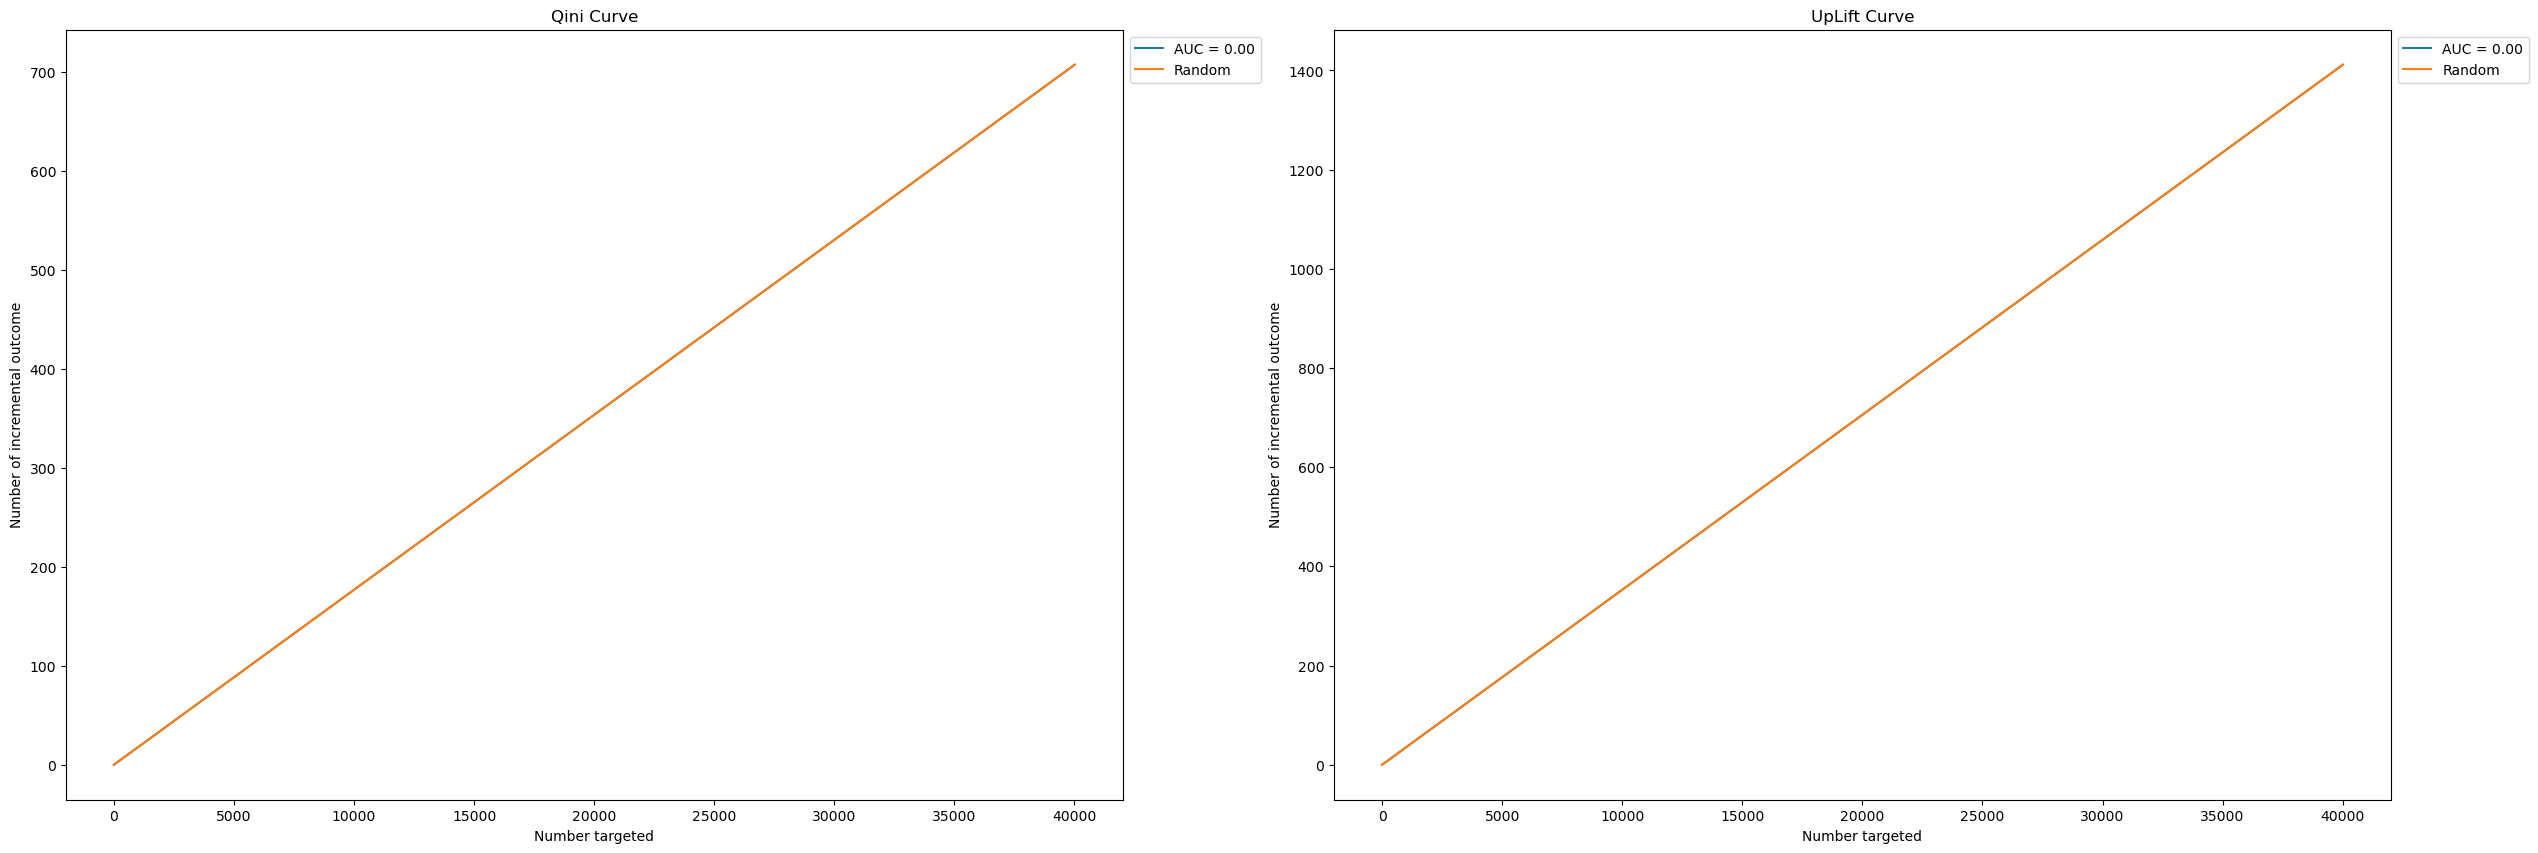

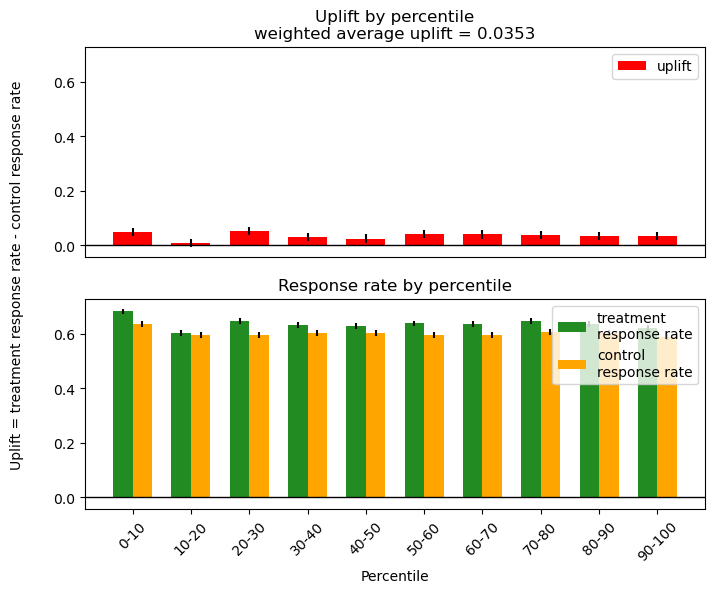

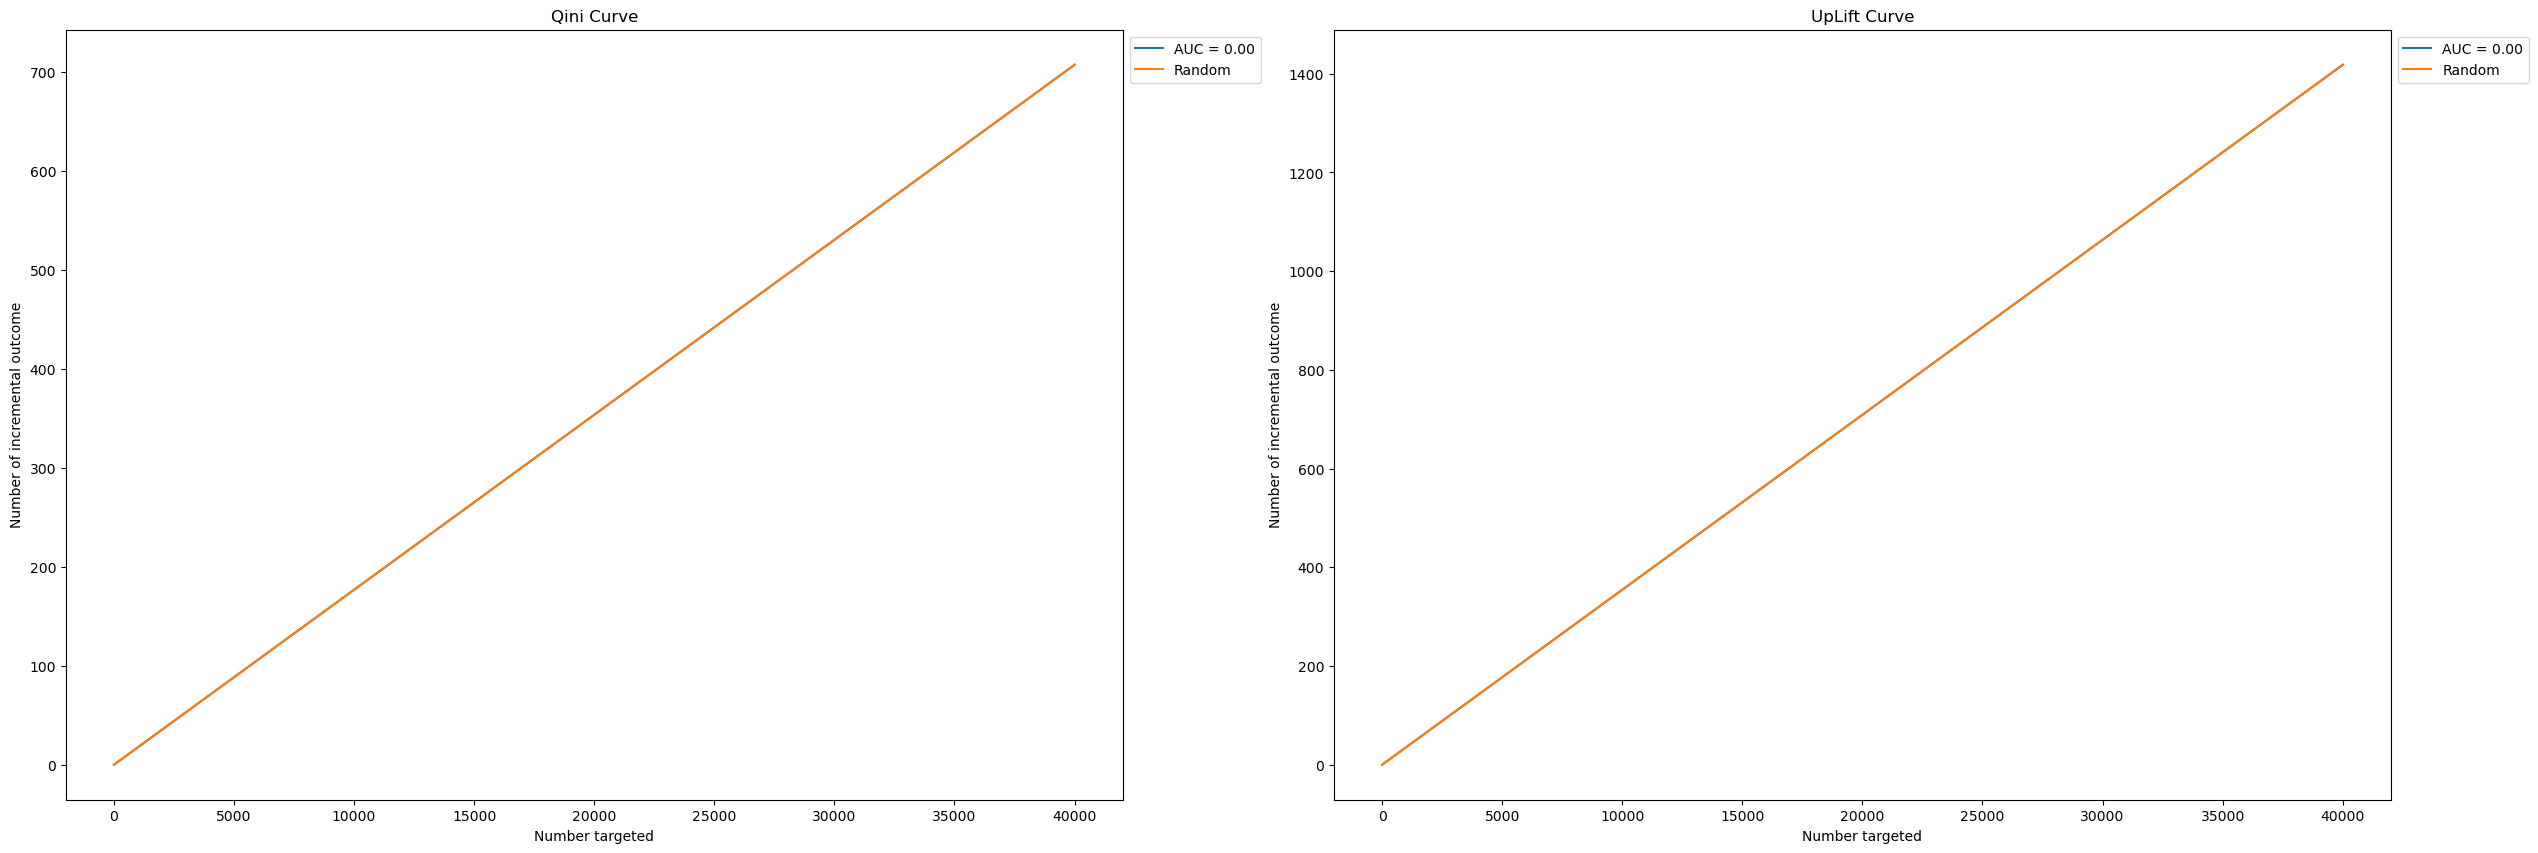

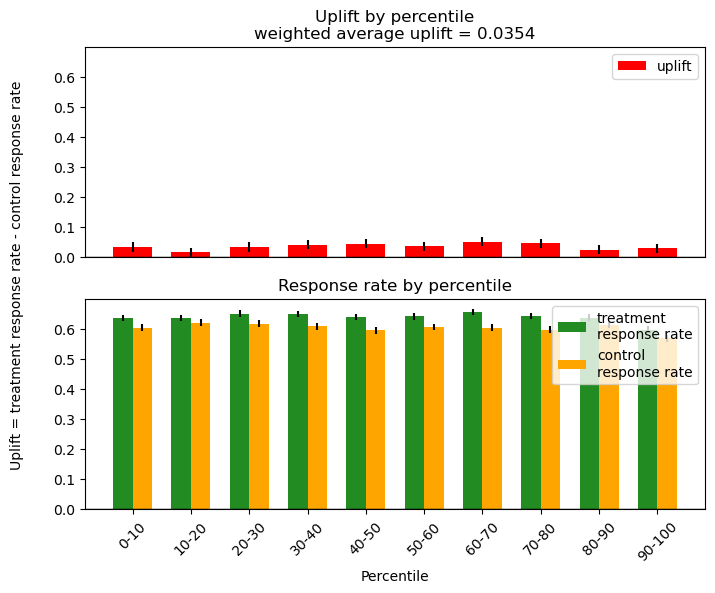

In [11]:
#Default data
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k':[]}
i = 0


for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      clf = CatBoostClassifier(verbose = 0)
      clf.fit(X_train_, y_train_)
      X_test_[:, -1] = 1#np.ones(len(test_index))
      y_pred1 = clf.predict_proba(X_test_).T[1]
      X_test_[:, -1] = 0#np.ones(len(test_index))
      y_pred0 = clf.predict_proba(X_test_).T[1]
      y_pred = y_pred1 - y_pred0
      del clf
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_overall = uplift_at_k(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift at 30% {uplift_overall}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/One model Split {i}.png")

      plot_uplift_by_percentile(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/One model Procentile Split {i}.png")



In [12]:
wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% = {uplift_overall}')

Mean WAU = 0.0332; Mean UpLift 30% = 0.0319


In [13]:
gc.collect()

77914

# Метод двух моделей

In [14]:


df= pd.read_csv(r'X5_clients_data_train.csv', sep = ';')
df.describe()
med = df.age.median()
df.age = df.age.apply(lambda x: x if((x >= 16) and (x <= 90)) else med)
df.age = df.age.fillna(med)
df.Mean_diffs = df.Mean_diffs.fillna(df.Mean_diffs.median()) 
df = df.fillna(0)
df.describe()

df = df.drop(['MeanItemCost', 'client_id'
                , 'Mean_TOP_1_BRAND'
                ,	'Mean_TOP_2_BRAND'
                ,	'Mean_TOP_3_BRAND'
                ,	'Mean_TOP_4_BRAND',
                	'Mean_TOP_5_BRAND',
                    'Mean_TOP_1_SEG',
                    'Mean_TOP_2_SEG',
                    'Mean_TOP_3_SEG',
                    'Mean_TOP_4_SEG',
                    'Mean_TOP_5_SEG',
                    'first_order_date'	], axis = 1)
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
treat = df.treatment_flg.values
X = df.iloc[:, 0:-1].values
X = (X - X.mean()) / X.std()
y = df.iloc[:, -1].values
del df
gc.collect()
X
y
# X_train, X_test, y_train, y_test = train_test_split(X, y)
# output.enable_custom_widget_manager()
# grid = {'learning_rate':  np.linspace(0, 0.05, 10)[1:-1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}
# clf = CatBoostClassifier(verbose = 0)  
# grid_search_result = clf.grid_search(grid, 
#                                        X=X_train, 
#                                        y=y_train, 
#                                        plot=True)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt







In [15]:

indxs = np.argwhere(X.T[-1] == 0)
indxs

array([], shape=(0, 1), dtype=int64)

Split 1; WAU = 0.03298384257098324; UpLift 30% 0.05461751383995972


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 2; WAU = 0.032418896327494374; UpLift 30% 0.04350695176383257


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 3; WAU = 0.03060371559054157; UpLift 30% 0.05345215051571339


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 4; WAU = 0.03562394699679438; UpLift 30% 0.055945349032074376


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 5; WAU = 0.03552132781979787; UpLift 30% 0.050474951785492106


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Mean WAU = 0.0334; Mean UpLift 30% = 0.0516


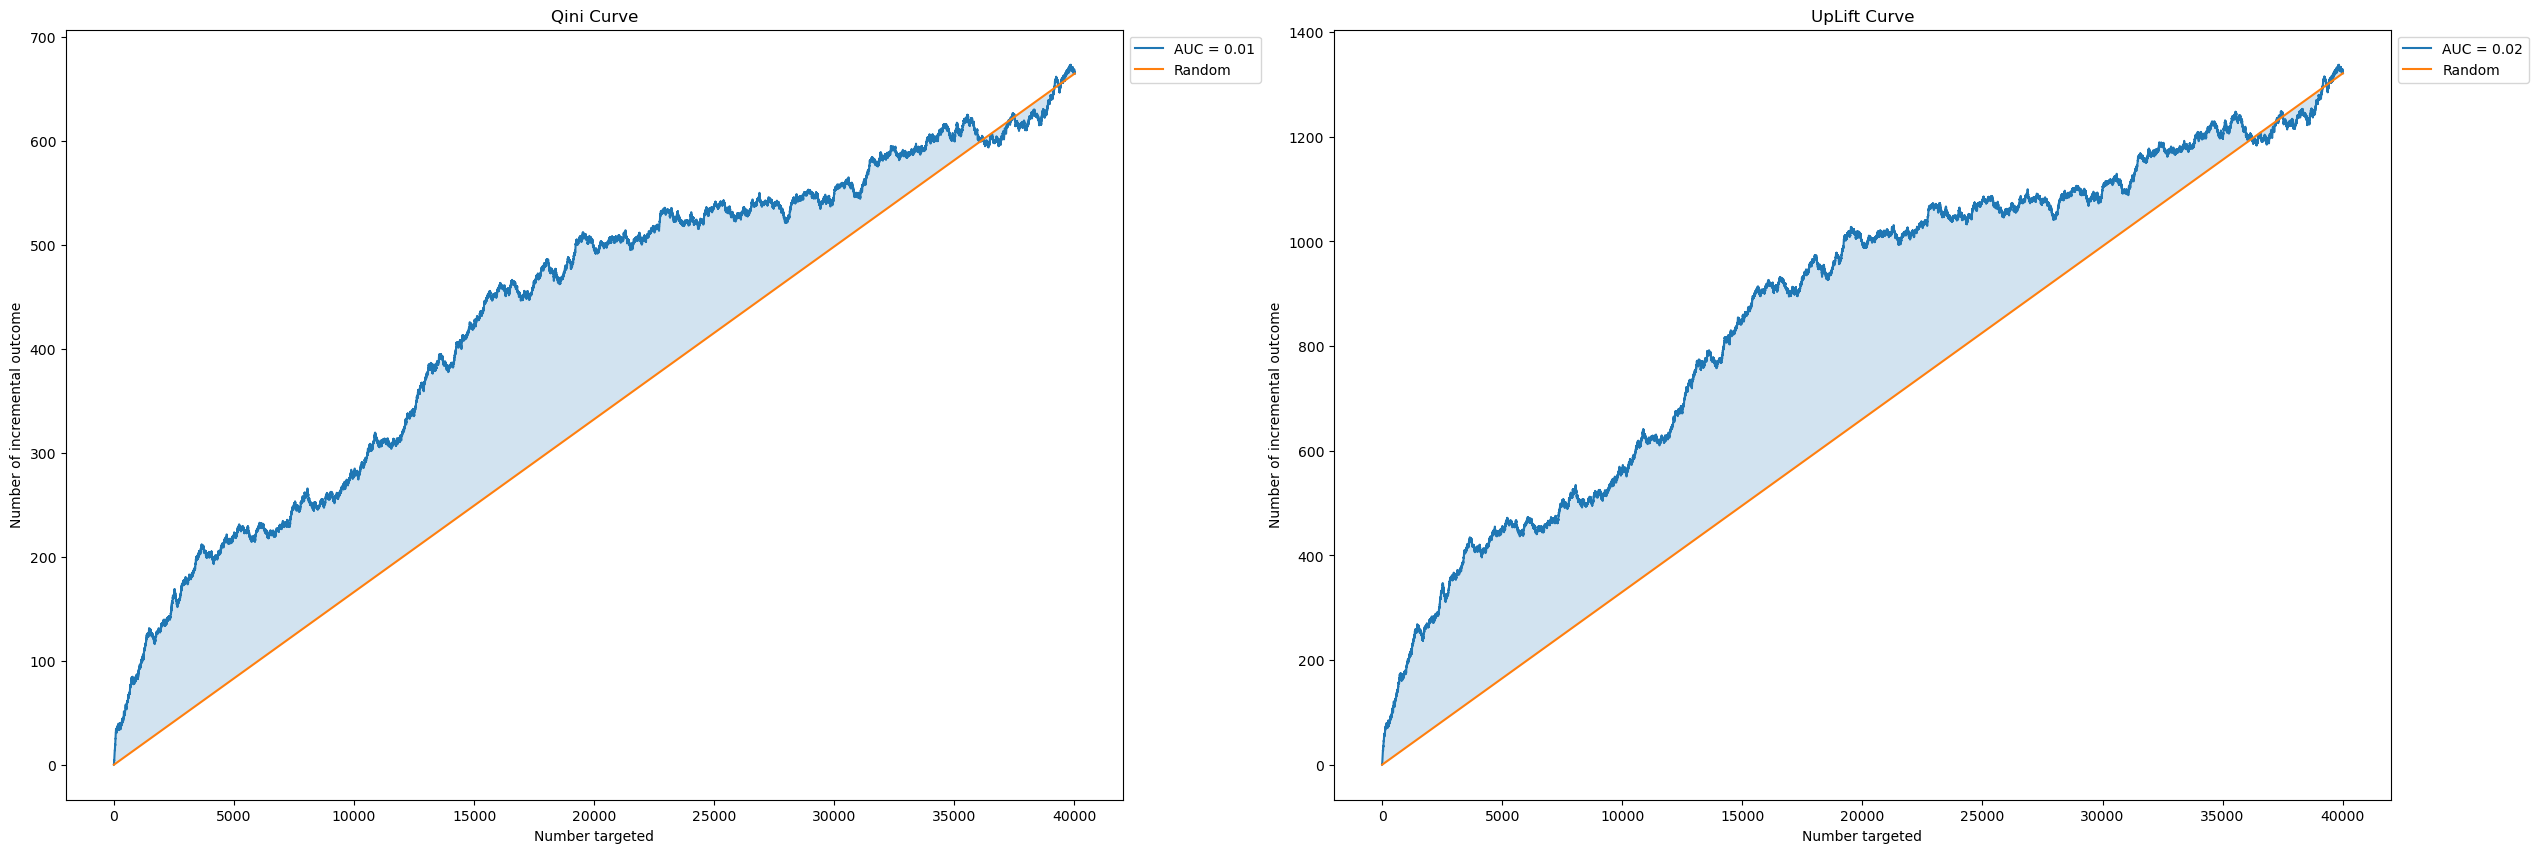

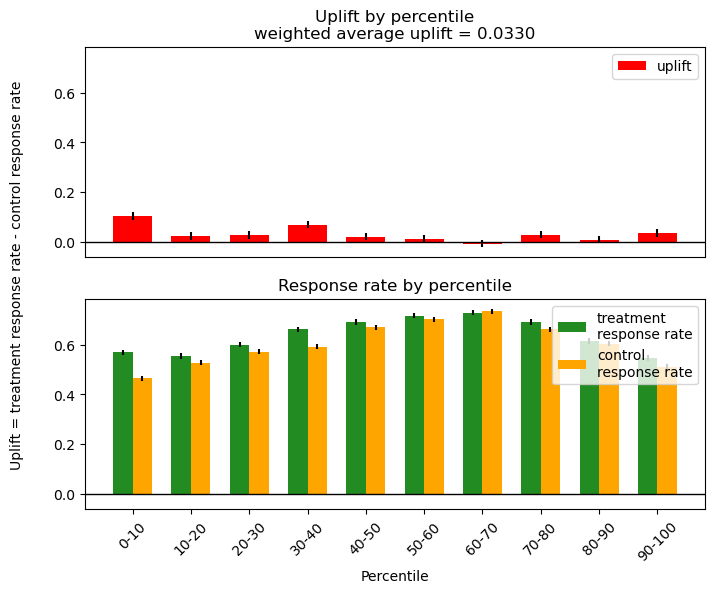

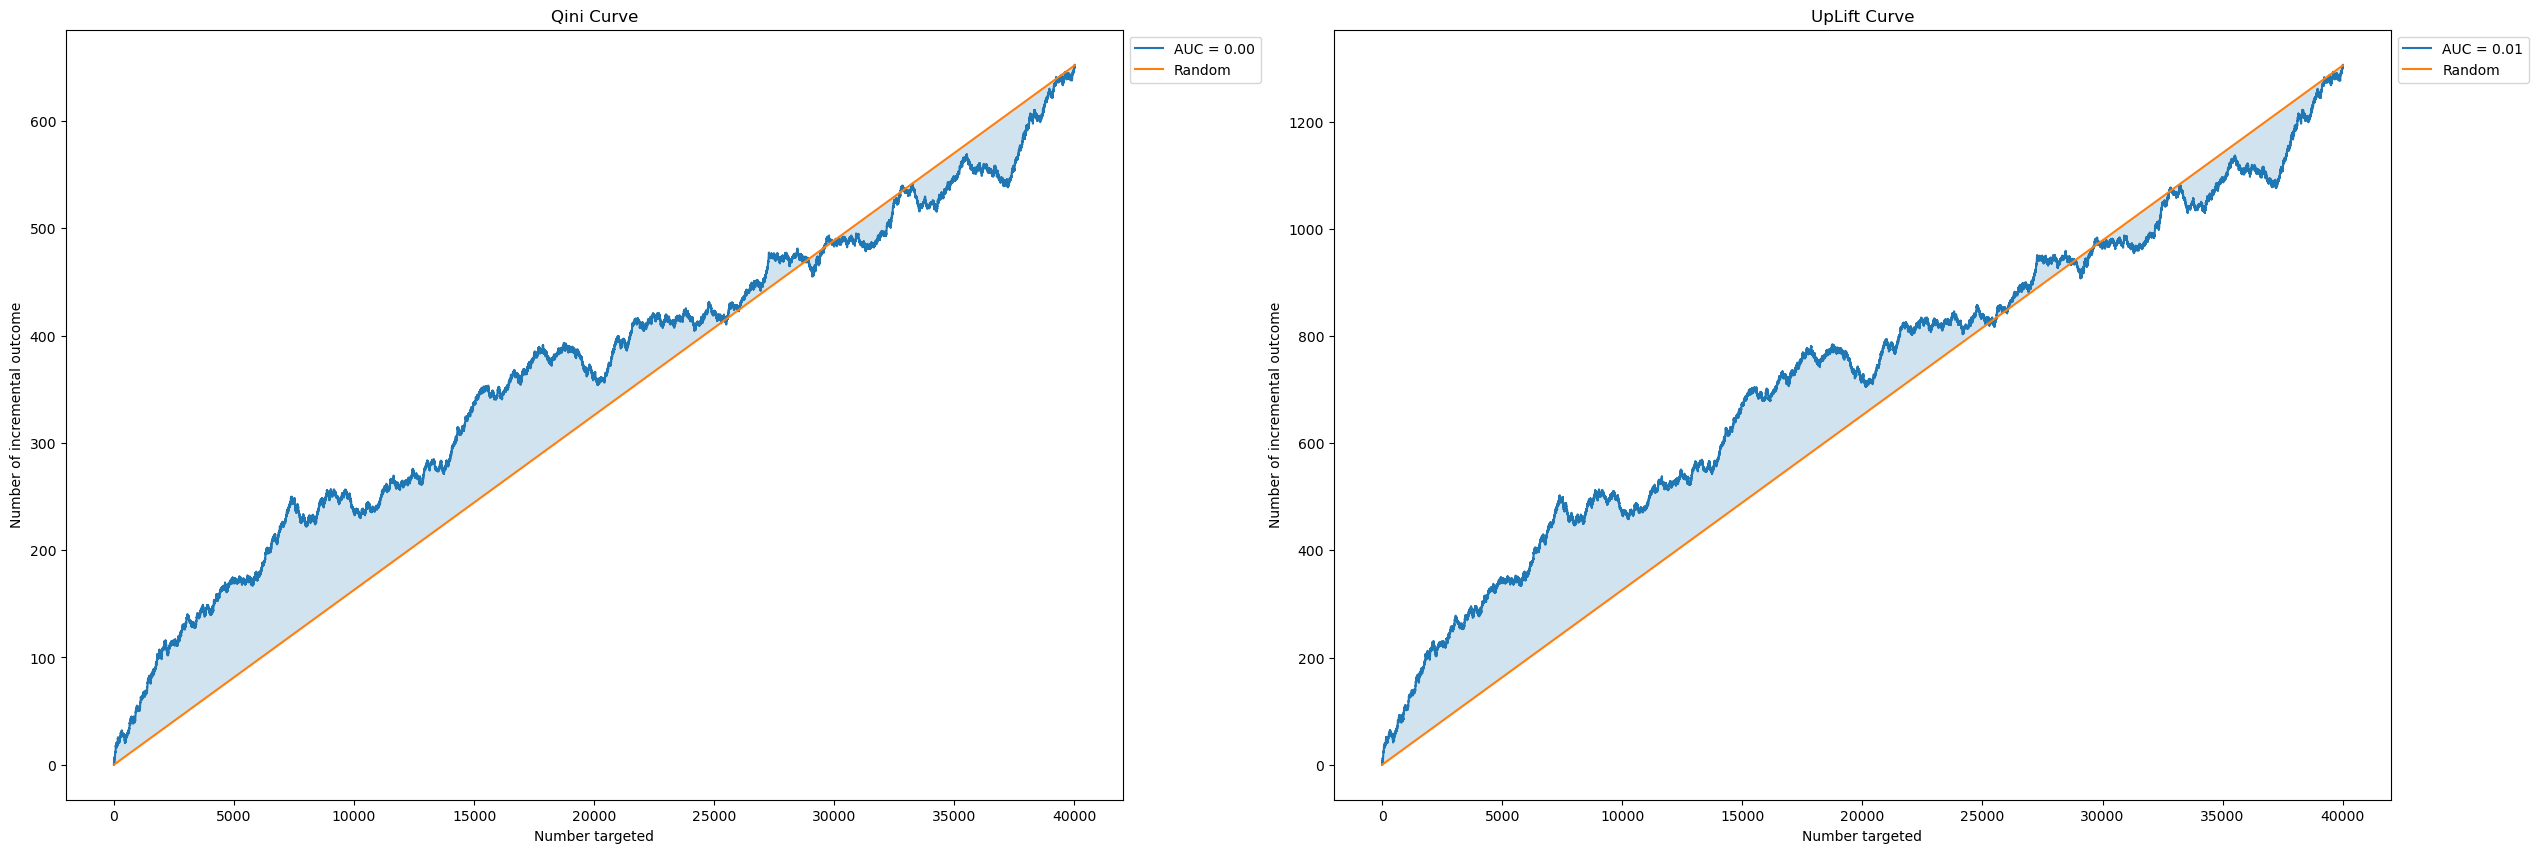

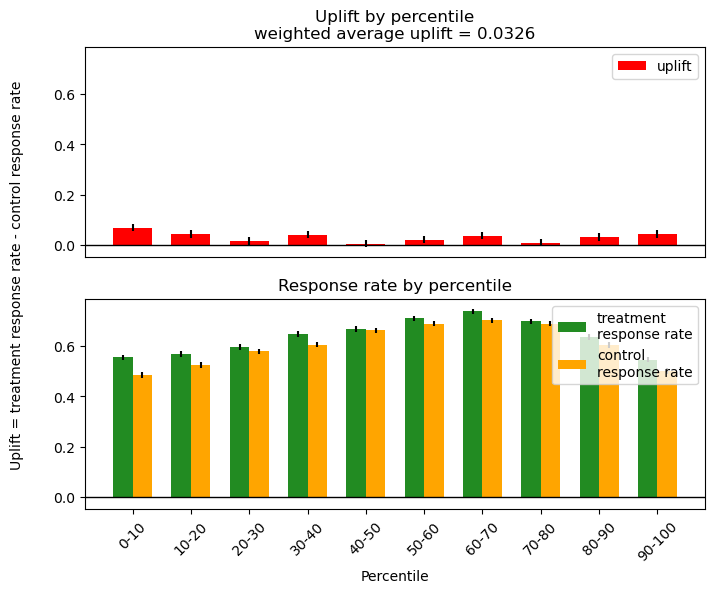

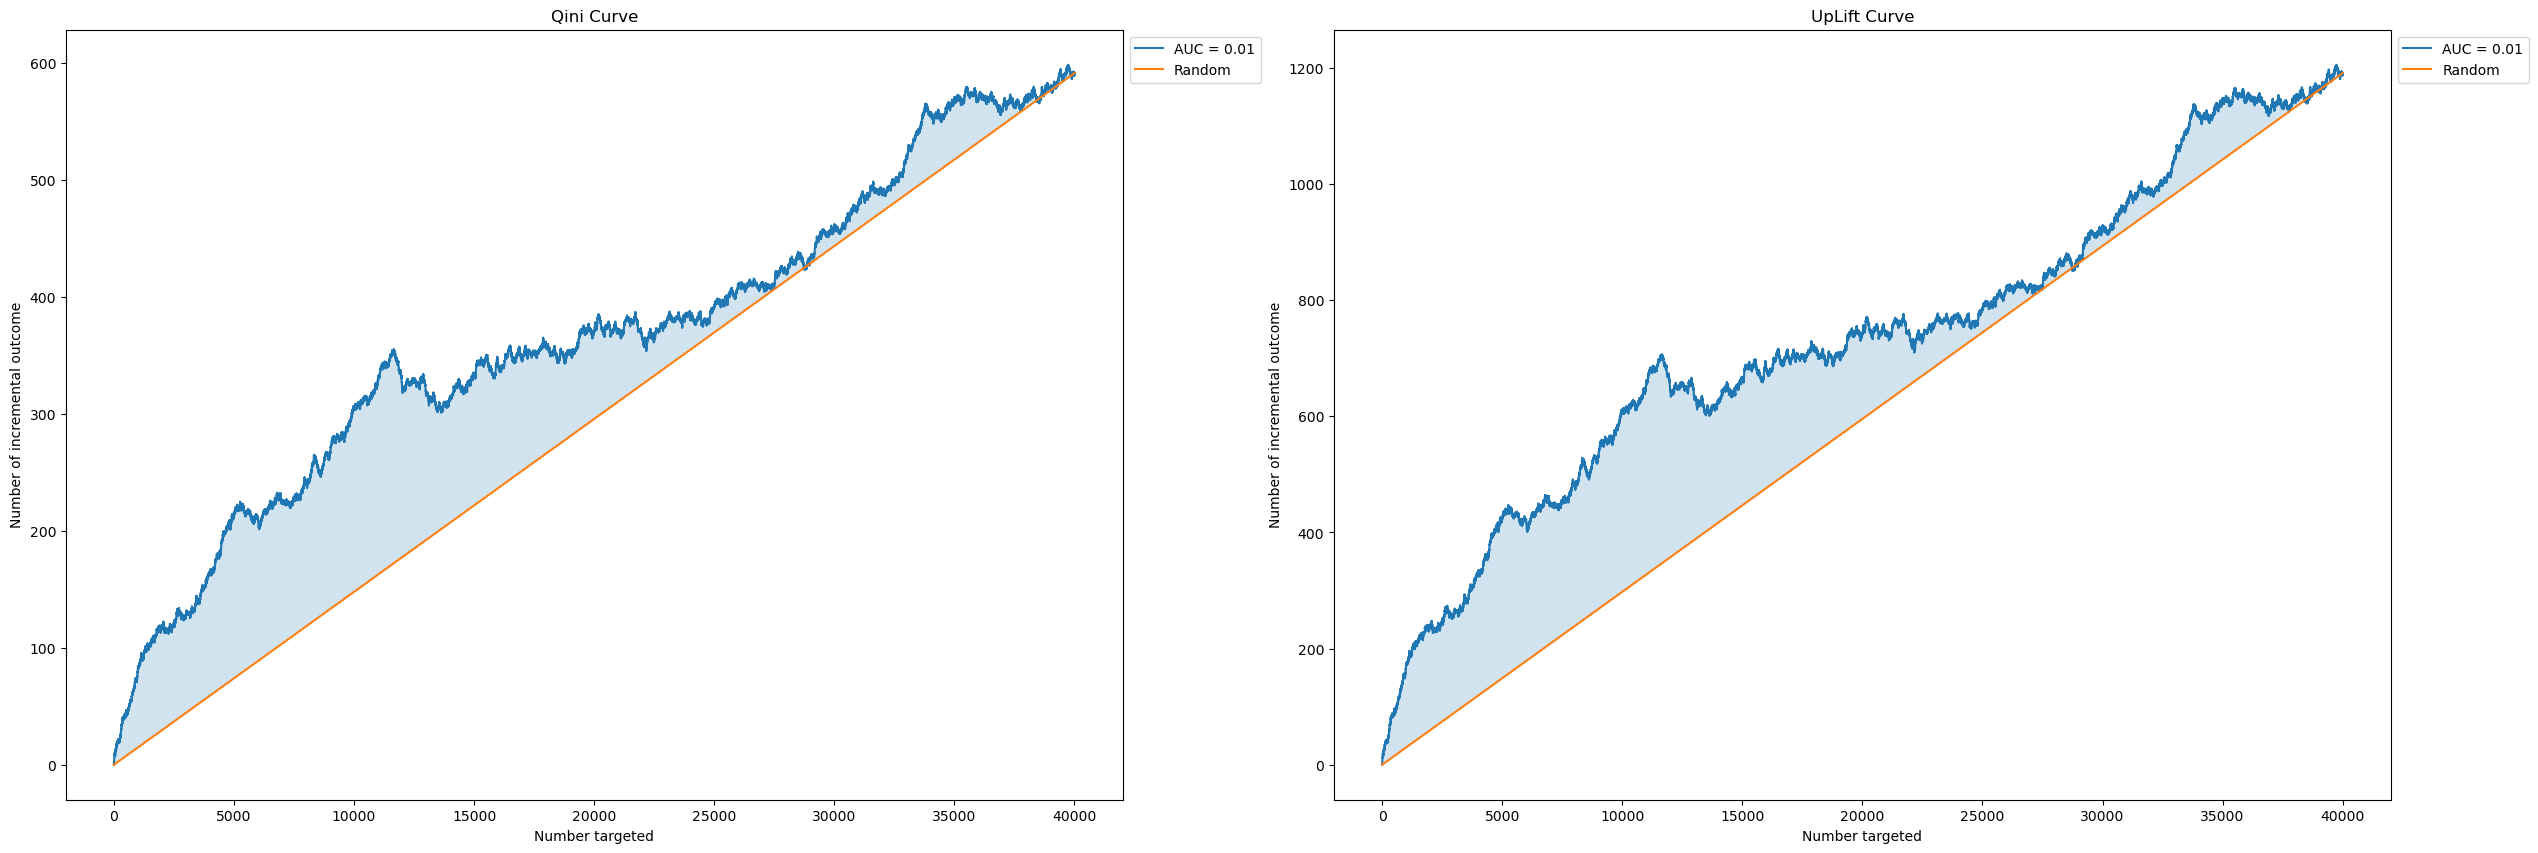

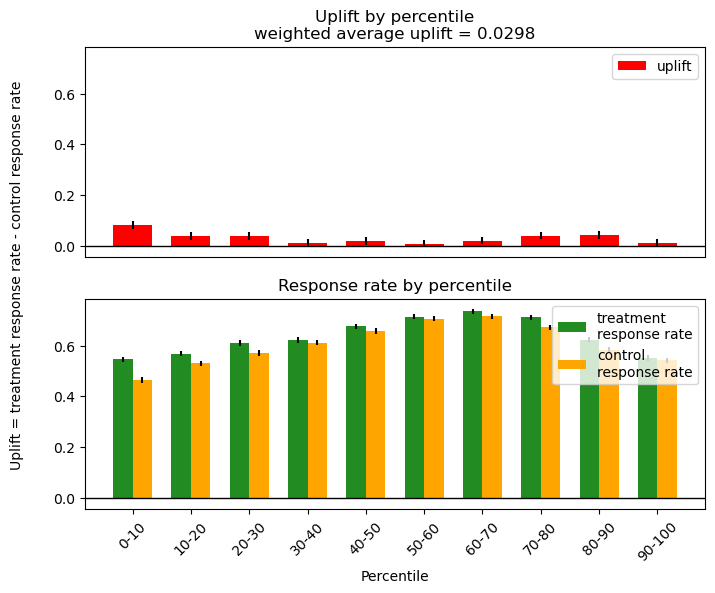

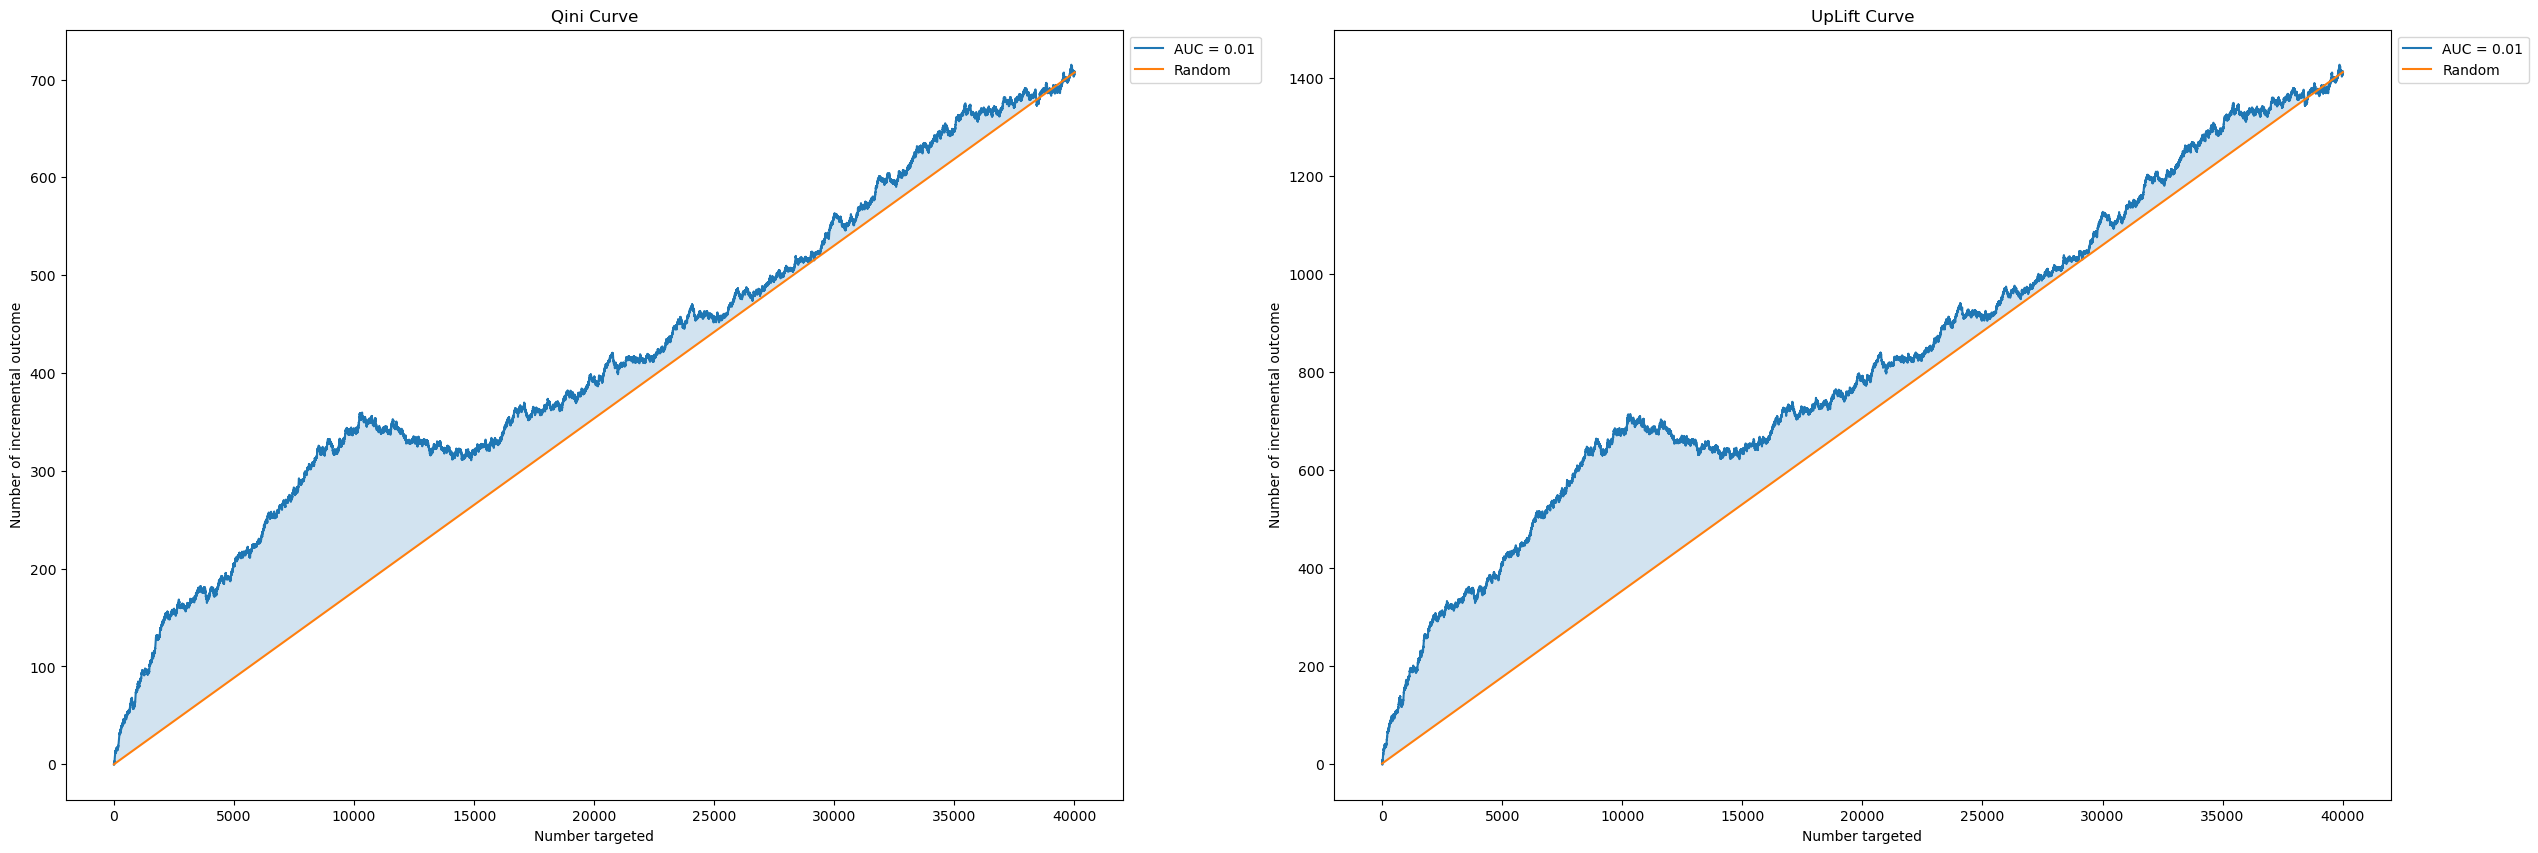

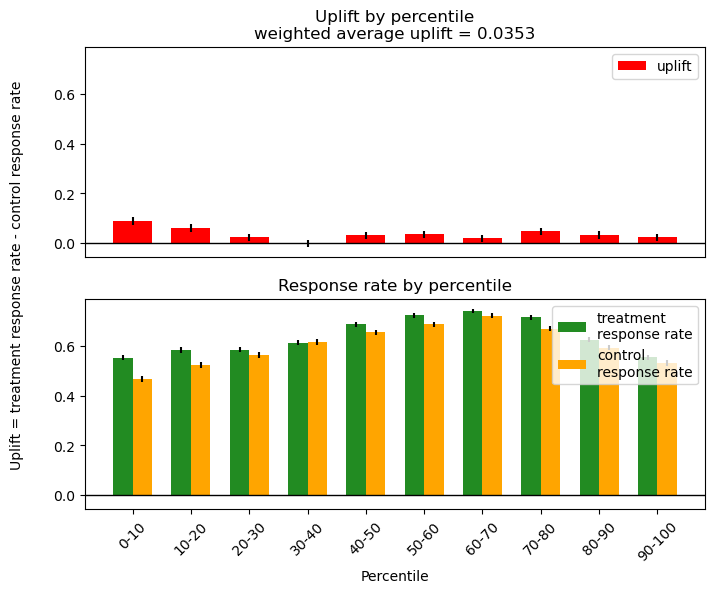

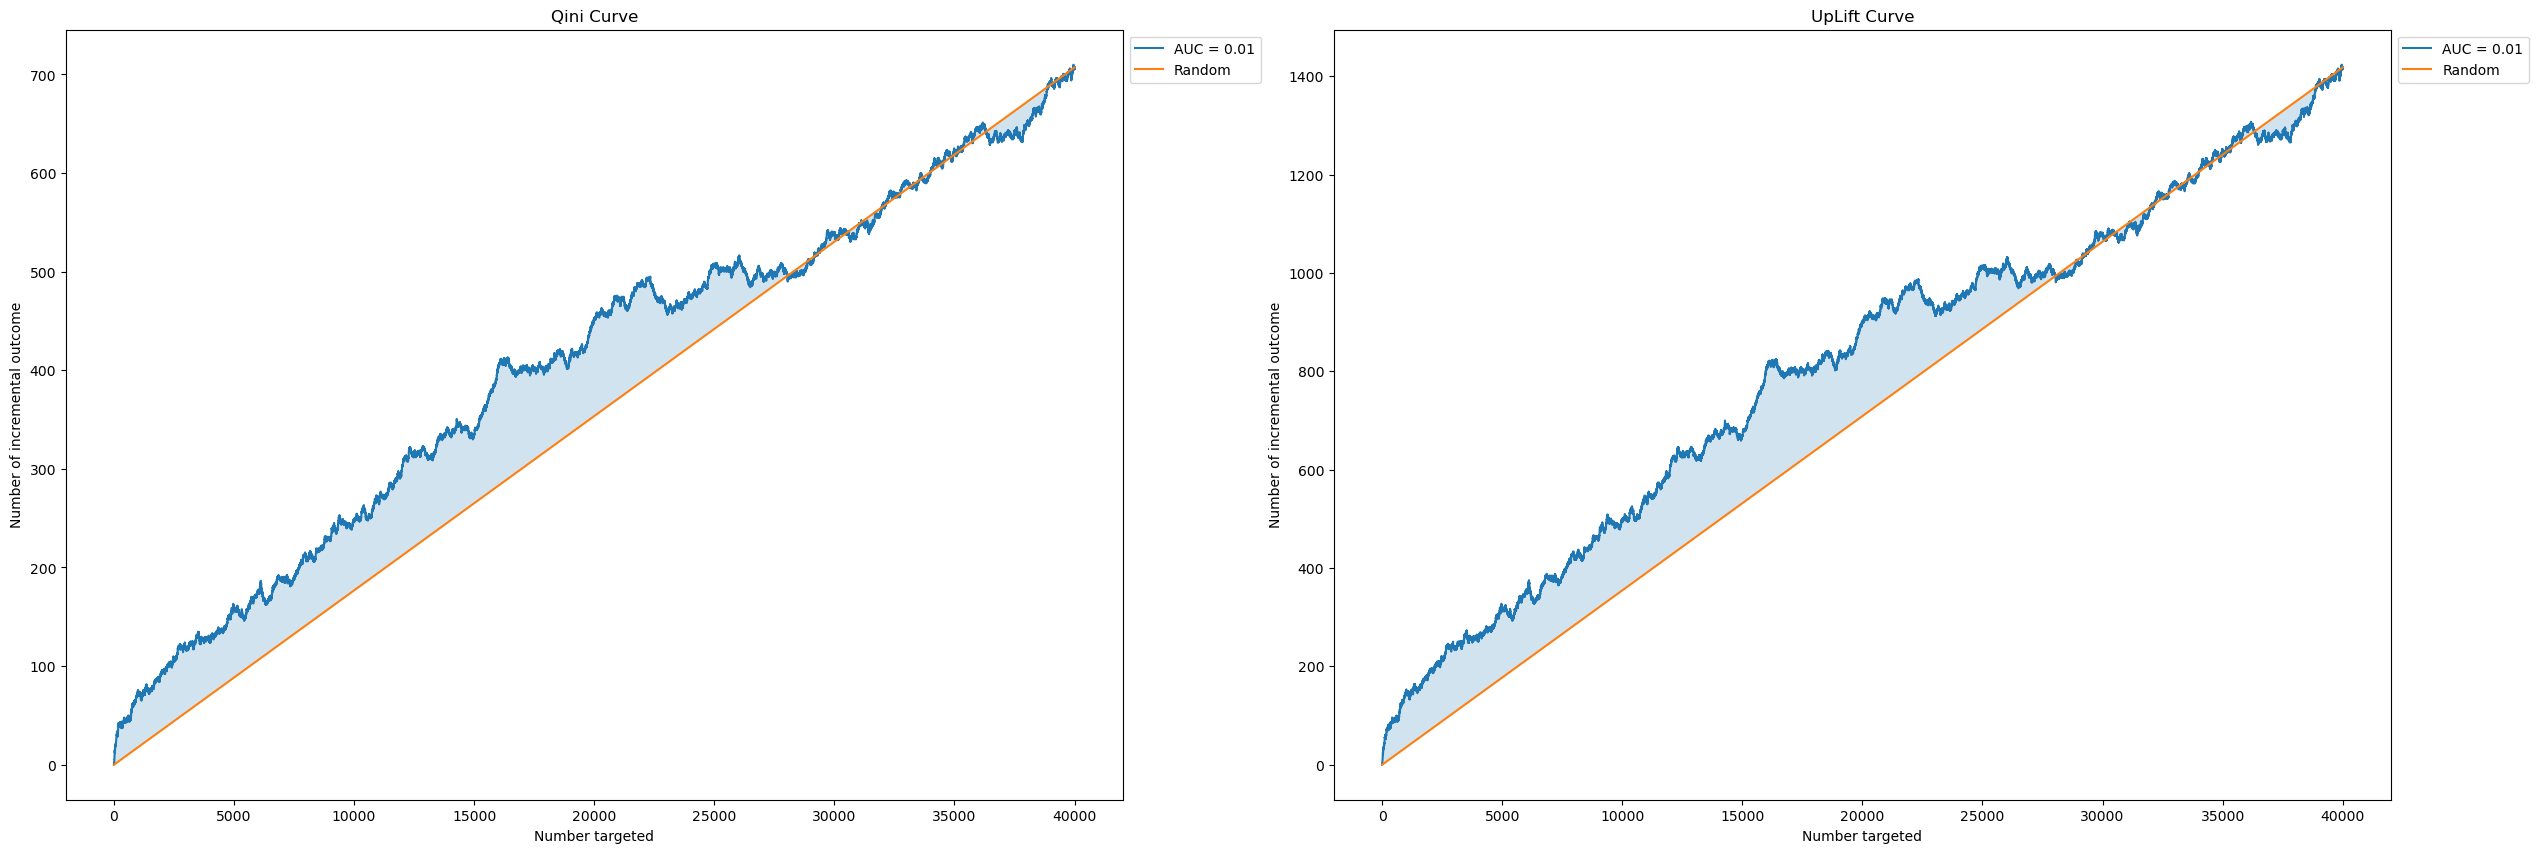

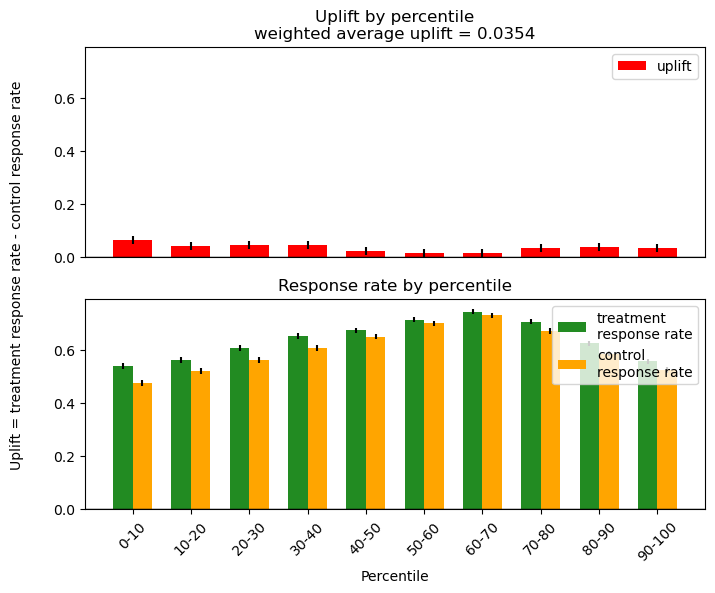

In [16]:
#Default data
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k':[]}
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      t_0 = np.argwhere(treat[train_index] == 0)
      t_1 = np.argwhere(treat[train_index] == 1)
      clf0 = CatBoostClassifier(verbose = 0, class_weights= [0.5, 0.5] )
      clf0.fit(np.squeeze(X_train_[t_0]), np.squeeze(y_train_[t_0]))
      clf1 = CatBoostClassifier(verbose = 0, class_weights= [0.5, 0.5] )
      clf1.fit(np.squeeze(X_train_[t_1]), np.squeeze(y_train_[t_1]))
      y_pred1 = clf1.predict_proba(X_test_).T[1]
      y_pred0 = clf0.predict_proba(X_test_).T[1]
      y_pred = y_pred1 - y_pred0
      del clf0
      del clf1
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_overall = uplift_at_k(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift 30% {uplift_overall}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/Two model Split {i}.png")

      plot_uplift_by_percentile(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/Two model Procentile Split {i}.png")


wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% = {uplift_overall}')

In [17]:
gc.collect()

77520

# Метод трансформации класса

In [18]:


df= pd.read_csv(r'X5_clients_data_train.csv', sep = ';')
med = df.age.median()
df.age = df.age.apply(lambda x: x if((x >= 16) and (x <= 90)) else med)
df.age = df.age.fillna(med)
df.Mean_diffs = df.Mean_diffs.fillna(df.Mean_diffs.median()) 
df = df.fillna(0)
df.describe()
display(df)







,client_id,regular_points_received,express_points_received,regular_points_spent,express_points_spent,regular_balance,express_balance,Total_Amount,Amount_BonusDiscount_purchs,BonusDiscount,...,PArt_CTM_purchs,cnt_alc_purchs,cnt_CTM_purchs,Mean_diffs,first_order_date,age,LoveBonuses,Gender,treatment_flg,target
0,27159c9807,17.1,0.0,0.0,0.0,17.1,0.0,2950.17,0.00,0.000000,...,0.000000,0,0,10.0,2018-11-26 13:09:43,26.0,0,-1,0,1
1,b1b5ea0726,21.2,0.0,6.0,0.0,15.2,0.0,2334.64,190.75,0.030496,...,0.800000,0,4,19.0,2018-12-22 10:20:58,35.0,0,-1,1,0
2,8399c72ebf,26.2,0.0,0.0,0.0,26.2,0.0,4534.55,0.00,0.000000,...,0.444444,0,8,6.0,2018-11-25 09:49:15,23.0,2,0,1,0
3,d5b8aff1ad,13.7,0.0,0.0,0.0,13.7,0.0,2359.99,0.00,0.000000,...,0.538462,0,7,5.0,2019-01-15 09:59:17,69.0,0,-1,1,1
4,a6fd598f71,90.4,0.0,149.0,0.0,-58.6,0.0,8259.32,1014.49,0.128063,...,0.647059,0,11,6.0,2018-11-27 09:50:48,23.0,0,-1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200034,fecd01be95,6.4,0.0,0.0,0.0,6.4,0.0,1398.80,0.00,0.000000,...,0.555556,0,5,13.0,2018-11-28 18:36:33,73.0,0,0,1,0
200035,929c68106b,12.9,0.0,0.0,0.0,12.9,0.0,2051.93,0.00,0.000000,...,1.000000,2,4,34.0,2018-11-30 16:56:31,69.0,0,0,0,1
200036,f183f1a613,19.9,0.0,36.0,40.0,-16.1,-40.0,4271.41,426.61,0.151211,...,0.307692,3,4,6.0,2018-12-18 11:48:22,43.0,0,-1,0,1
200037,226757e95c,12.1,0.0,0.0,0.0,12.1,0.0,2737.92,0.00,0.000000,...,0.769231,1,10,8.0,2018-11-26 15:11:55,29.0,0,0,1,0


In [19]:
df = df.drop(['MeanItemCost', 'client_id'
                , 'Mean_TOP_1_BRAND'
                ,	'Mean_TOP_2_BRAND'
                ,	'Mean_TOP_3_BRAND'
                ,	'Mean_TOP_4_BRAND',
                	'Mean_TOP_5_BRAND',
                    'Mean_TOP_1_SEG',
                    'Mean_TOP_2_SEG',
                    'Mean_TOP_3_SEG',
                    'Mean_TOP_4_SEG',
                    'Mean_TOP_5_SEG',
                    'first_order_date'	], axis = 1)
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
treat = df.treatment_flg.values
targ = df.target.values
treat

array([0, 1, 1, ..., 0, 1, 0], dtype=int64)

In [20]:

p = df[df.treatment_flg == 1].shape[0] / df.shape[0]
X = df.iloc[:, 0:-2].values
X = (X - X.mean()) / X.std()
y = df.target * (df.treatment_flg - p) / (1- p) / p
y = y.values
del df
gc.collect()
print(X)
print(y)
print(p)
# X_train, X_test, y_train, y_test = train_test_split(X, y)
# output.enable_custom_widget_manager()
# grid = {'learning_rate':  np.linspace(0, 0.05, 10)[1:-1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}
# clf = CatBoostClassifier(verbose = 0)  
# grid_search_result = clf.grid_search(grid, 
#                                        X=X_train, 
#                                        y=y_train, 
#                                        plot=True)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


[[-0.14500764 -0.15234497 -0.15234497 ... -0.14118879 -0.15234497
  -0.15277405]
 [-0.14324839 -0.15234497 -0.14977047 ... -0.13732704 -0.15234497
  -0.15277405]
 [-0.14110297 -0.15234497 -0.15234497 ... -0.14247604 -0.1514868
  -0.15234497]
 ...
 [-0.1438062  -0.15234497 -0.13689795 ... -0.13389437 -0.15234497
  -0.15277405]
 [-0.14715306 -0.15234497 -0.15234497 ... -0.13990154 -0.15234497
  -0.15234497]
 [-0.12085022 -0.15234497 -0.15234497 ... -0.14161787 -0.15234497
  -0.15277405]]
[-1.99923045  0.          0.         ... -1.99923045  0.
 -1.99923045]
0.4998075375301816


Split 1; WAU = 0.033143369358854174; UpLift 30% = 0.04870106833856147


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 2; WAU = 0.03277678784321869; UpLift 30% = 0.03781001675415374


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 3; WAU = 0.028664234661291203; UpLift 30% = 0.03995869339819291


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 4; WAU = 0.03508747915405973; UpLift 30% = 0.039592487788181474


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 5; WAU = 0.0346772915194722; UpLift 30% = 0.039508679441436656


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Mean WAU = 0.0329; Mean UpLift 30% = 0.0411


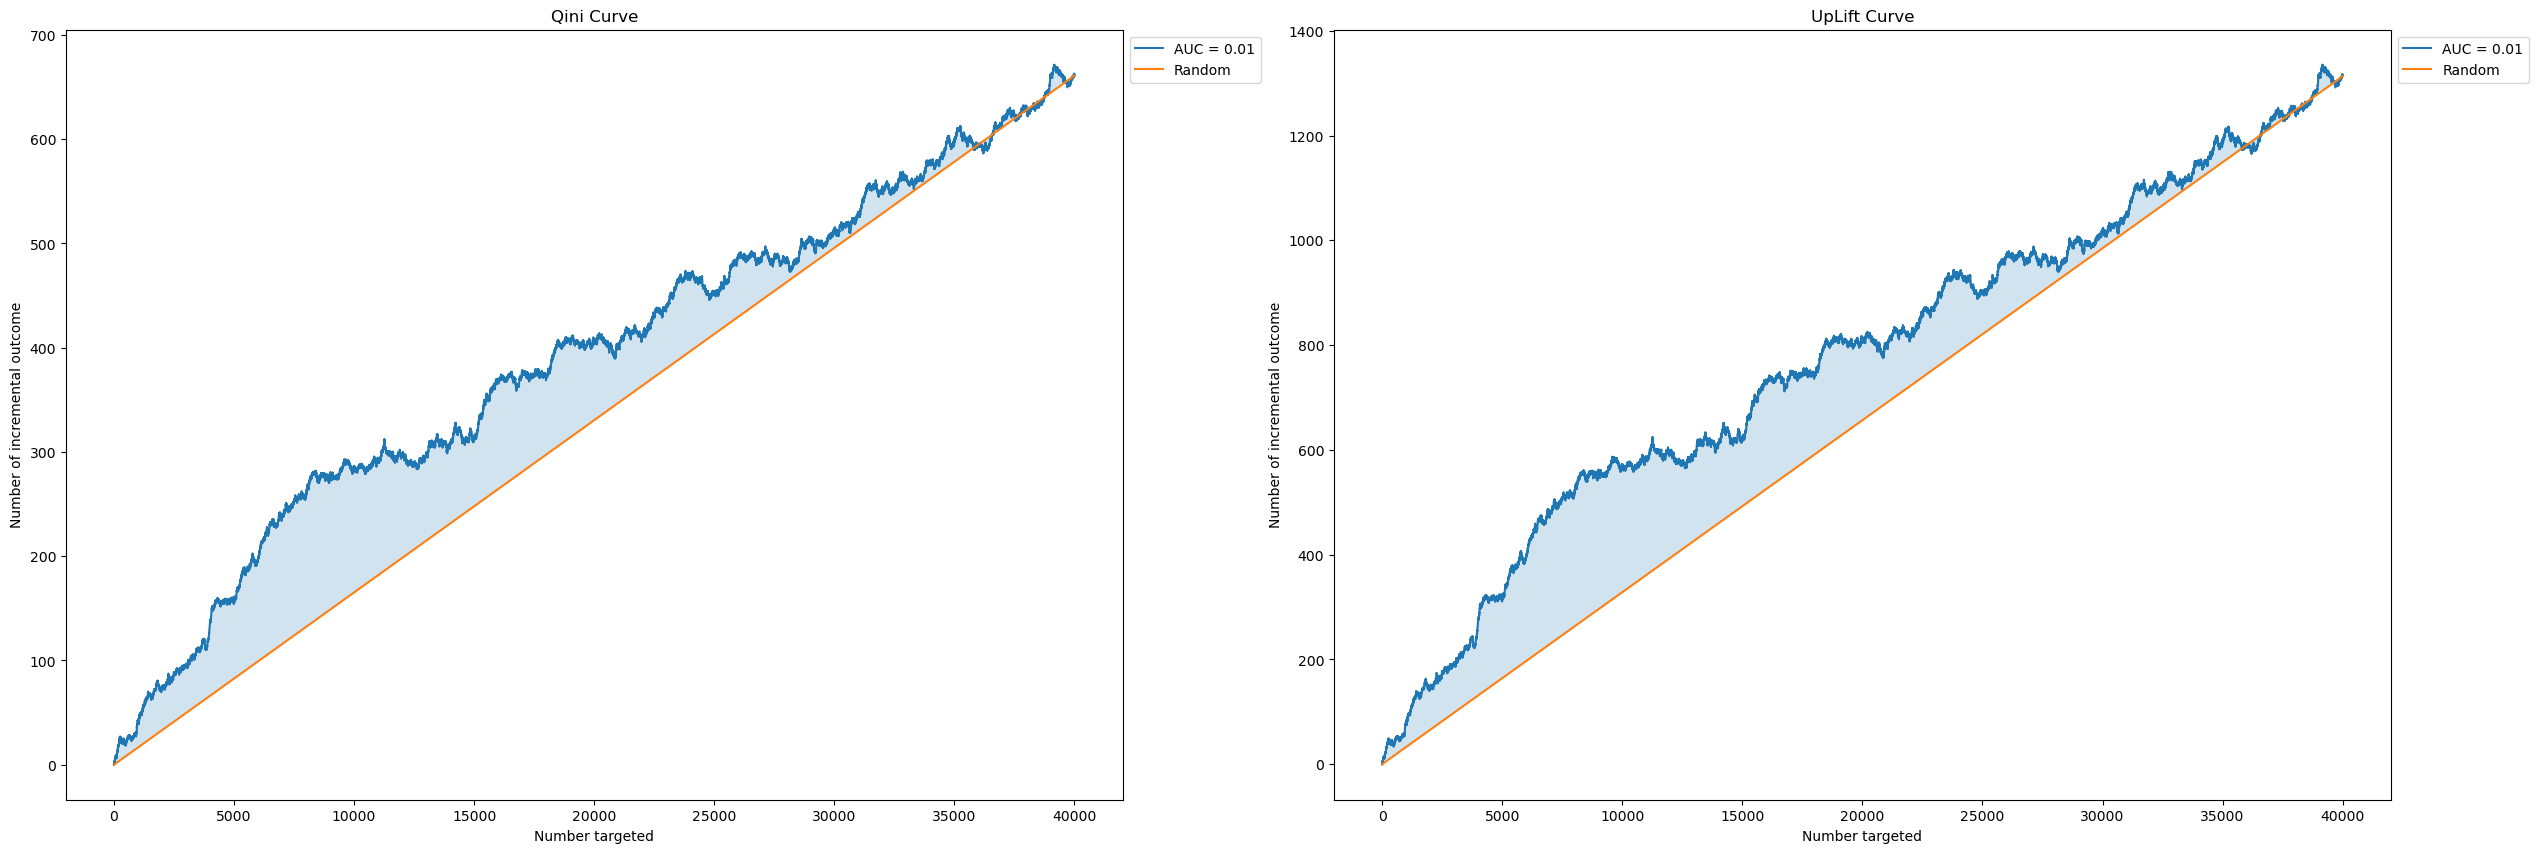

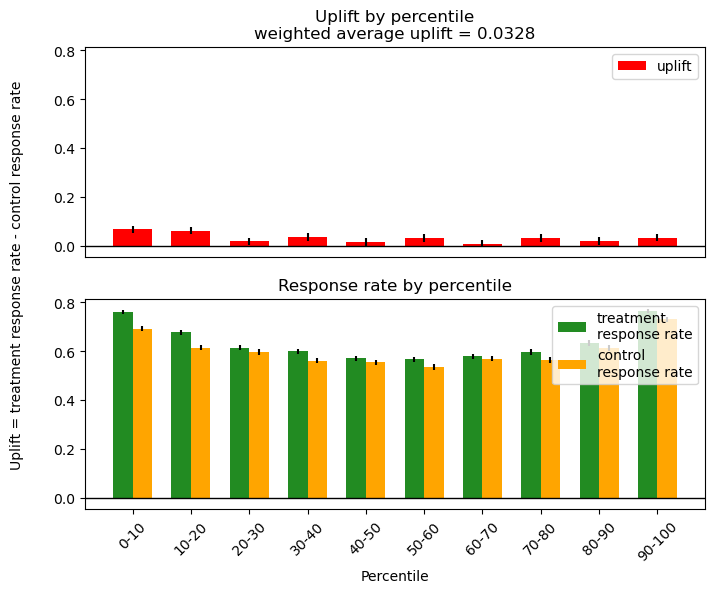

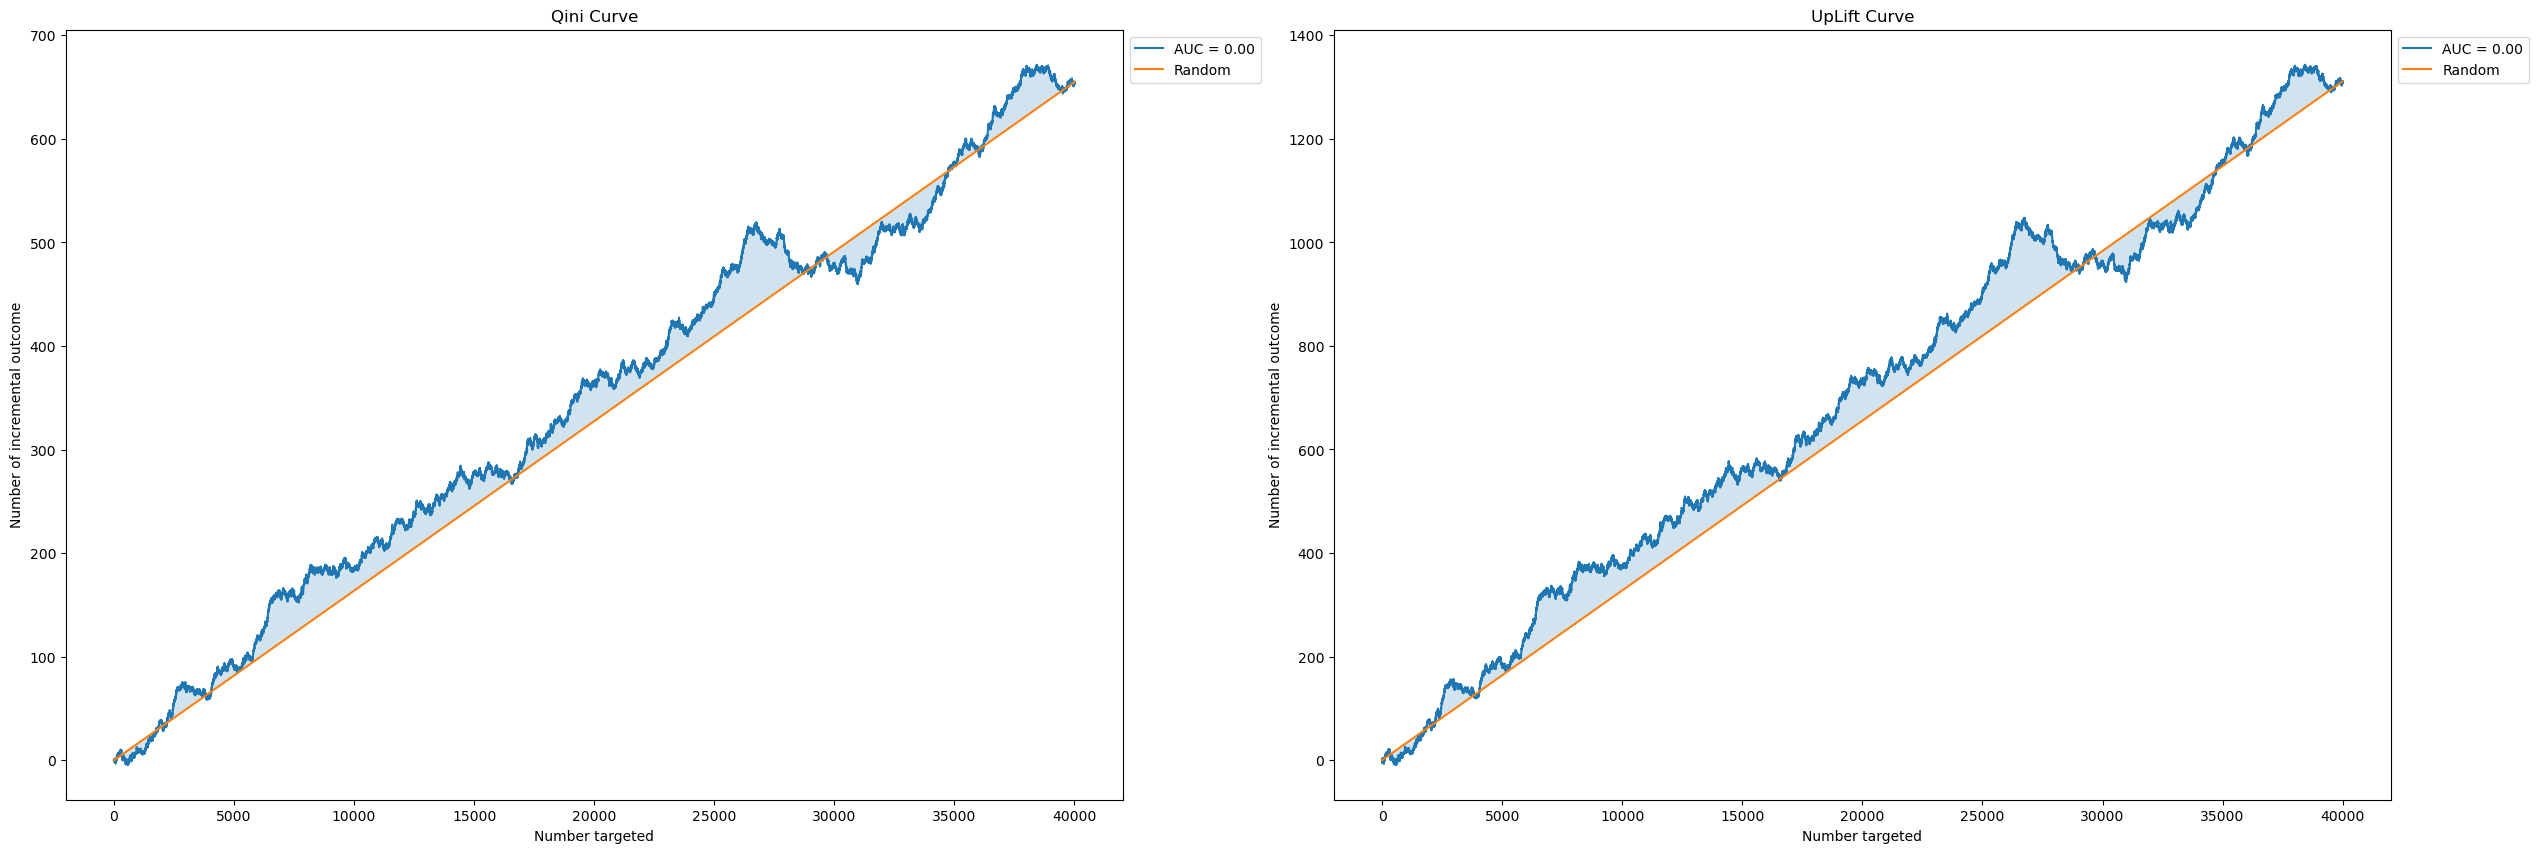

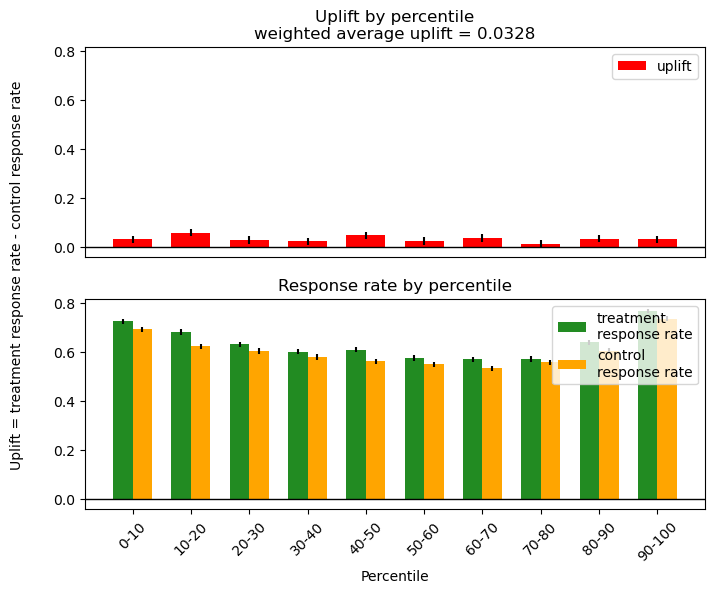

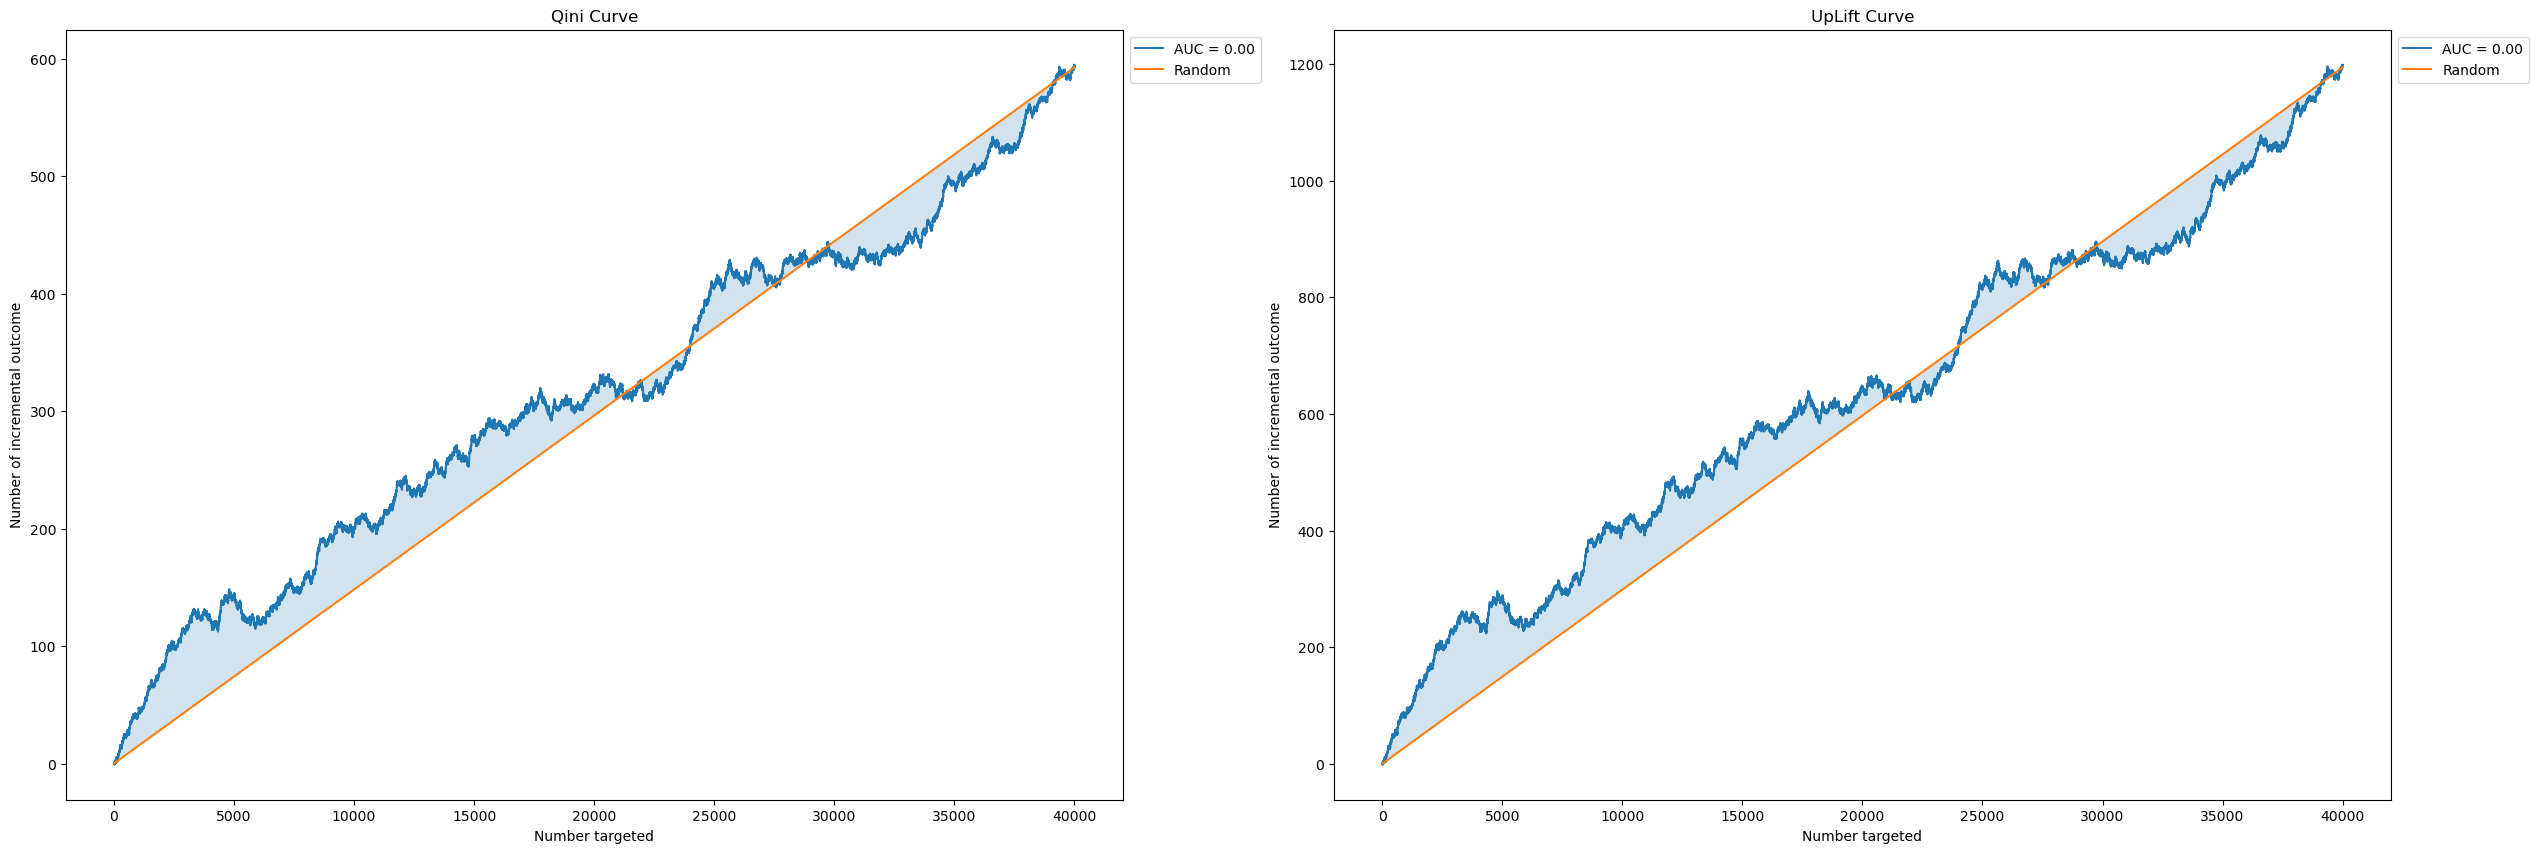

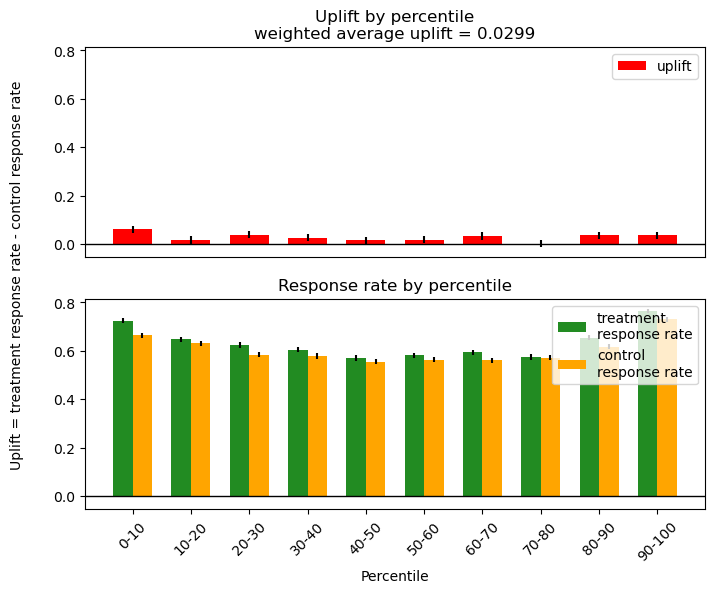

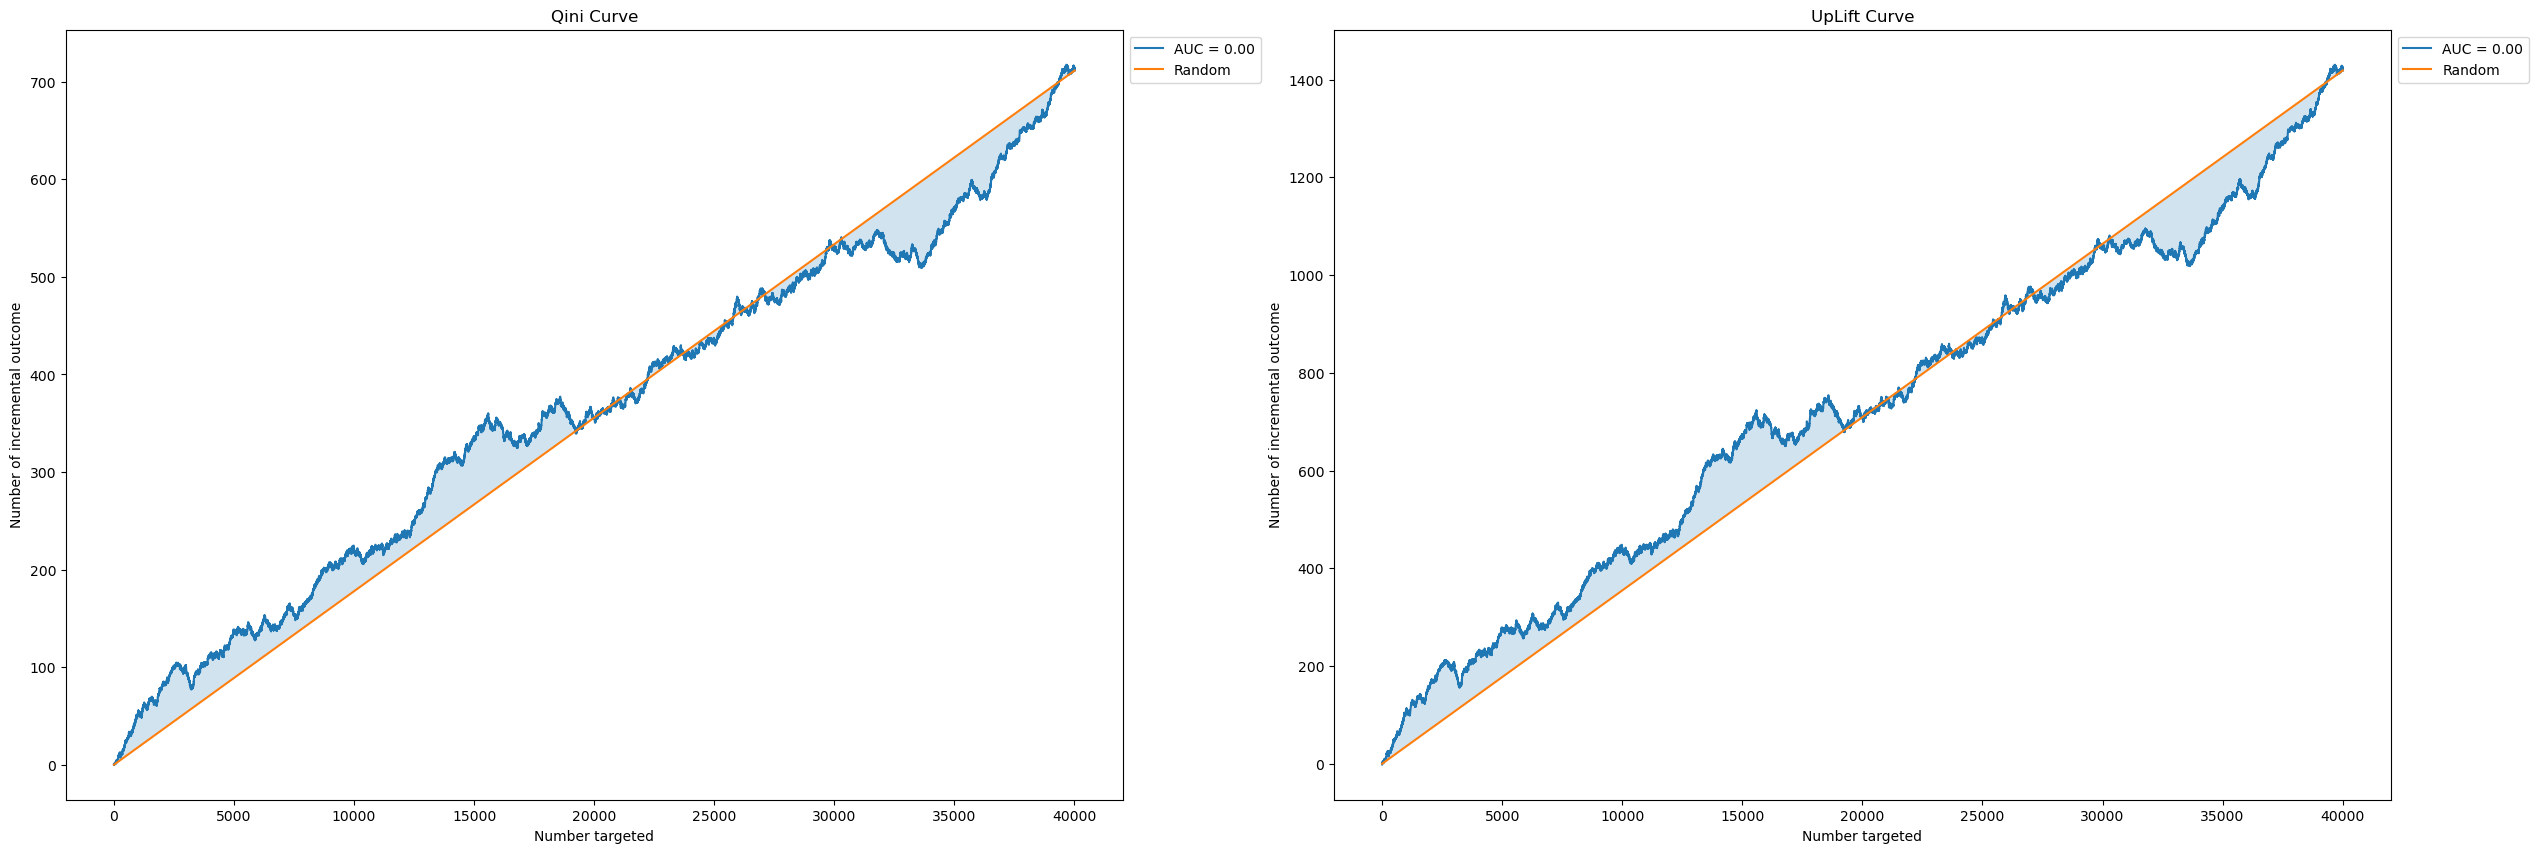

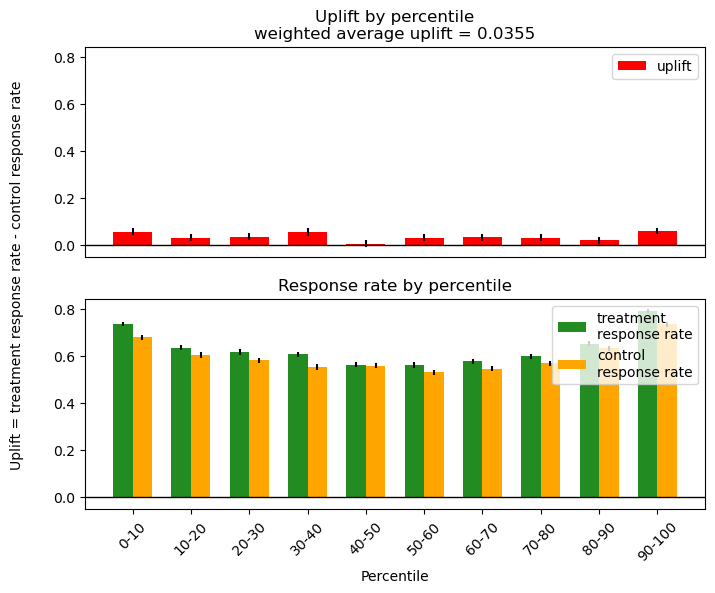

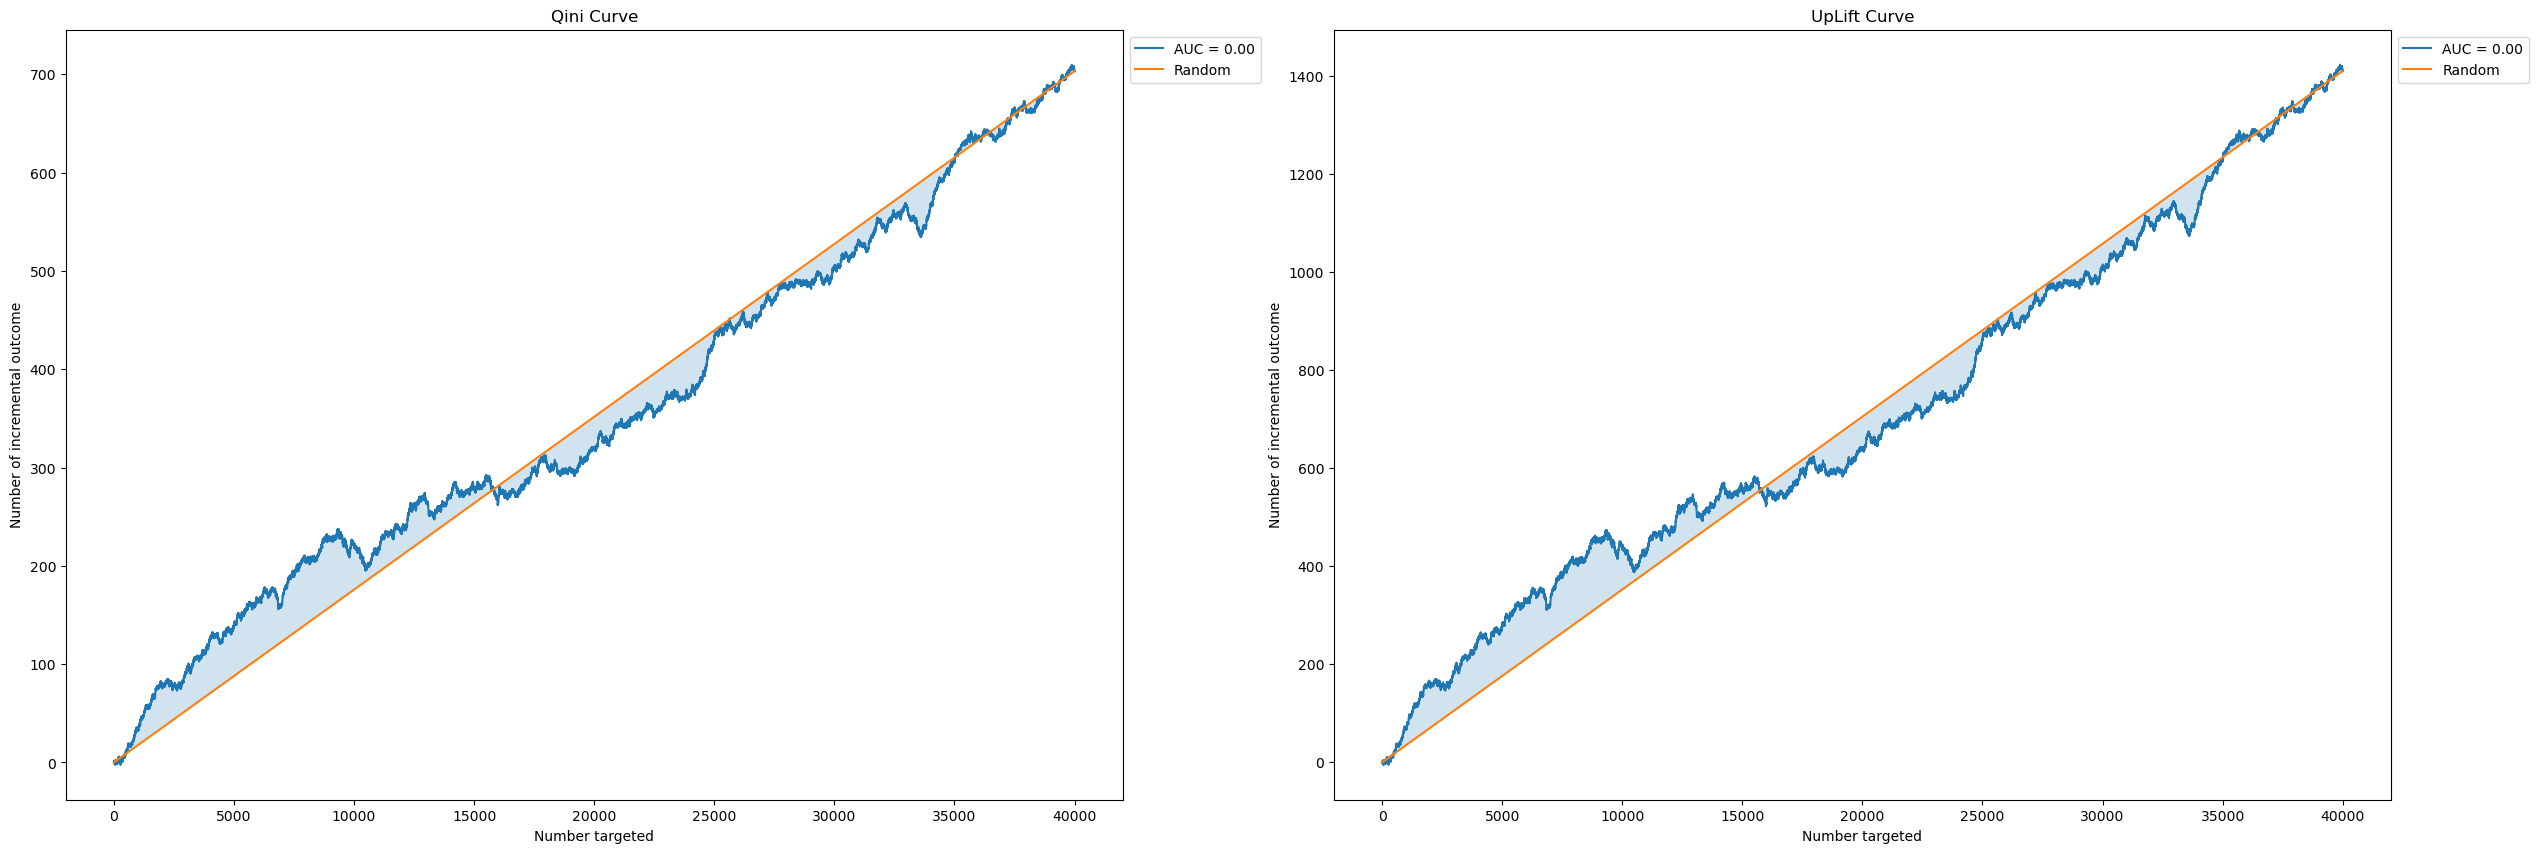

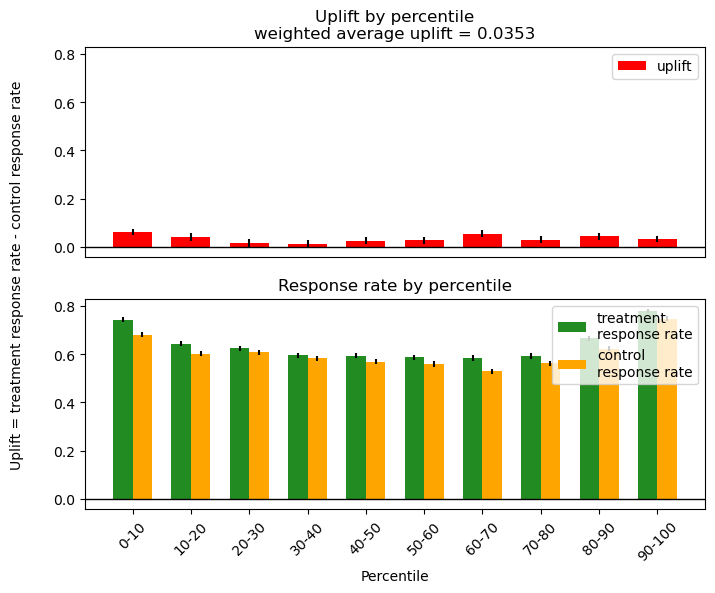

In [21]:
# Метод двух моделей
#Default data
skf = KFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k':[]}
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      reg = CatBoostRegressor(verbose=0)
      reg.fit(X_train_, y_train_)
      y_pred = reg.predict(X_test_)
      del reg
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_overall = uplift_at_k(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift 30% = {uplift_overall}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/Regression model Split {i}.png")

      plot_uplift_by_percentile(y_true=targ[test_index], uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/Regression model Procentile Split {i}.png")


wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% = {uplift_overall}')


In [22]:
gc.collect()

78901

# AutoML

In [23]:


df= pd.read_csv(r'X5_clients_data_train.csv', sep = ';')
med = df.age.median()
df.age = df.age.apply(lambda x: x if((x >= 16) and (x <= 90)) else med)
df.age = df.age.fillna(med)
df.Mean_diffs = df.Mean_diffs.fillna(df.Mean_diffs.median()) 
df = df.fillna(0)
df.describe()
display(df)






df = df.drop(['MeanItemCost', 'client_id'
                , 'Mean_TOP_1_BRAND'
                ,	'Mean_TOP_2_BRAND'
                ,	'Mean_TOP_3_BRAND'
                ,	'Mean_TOP_4_BRAND',
                	'Mean_TOP_5_BRAND',
                    'Mean_TOP_1_SEG',
                    'Mean_TOP_2_SEG',
                    'Mean_TOP_3_SEG',
                    'Mean_TOP_4_SEG',
                    'Mean_TOP_5_SEG',
                    'first_order_date'	], axis = 1)
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
treat = df.treatment_flg.values
targ = df.target.values
treat

p = df[df.treatment_flg == 1].shape[0] / df.shape[0]
X = df.iloc[:, 0:-2].values
#X = (X - X.mean()) / X.std()
y = df.target * (df.treatment_flg - p) / (1- p) / p
y = y.values
features = df.columns.tolist()
del df
gc.collect()
print(X)
print(y)
print(p)
# X_train, X_test, y_train, y_test = train_test_split(X, y)
# output.enable_custom_widget_manager()
# grid = {'learning_rate':  np.linspace(0, 0.05, 10)[1:-1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}
# clf = CatBoostClassifier(verbose = 0)  
# grid_search_result = clf.grid_search(grid, 
#                                        X=X_train, 
#                                        y=y_train, 
#                                        plot=True)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


,client_id,regular_points_received,express_points_received,regular_points_spent,express_points_spent,regular_balance,express_balance,Total_Amount,Amount_BonusDiscount_purchs,BonusDiscount,...,PArt_CTM_purchs,cnt_alc_purchs,cnt_CTM_purchs,Mean_diffs,first_order_date,age,LoveBonuses,Gender,treatment_flg,target
0,27159c9807,17.1,0.0,0.0,0.0,17.1,0.0,2950.17,0.00,0.000000,...,0.000000,0,0,10.0,2018-11-26 13:09:43,26.0,0,-1,0,1
1,b1b5ea0726,21.2,0.0,6.0,0.0,15.2,0.0,2334.64,190.75,0.030496,...,0.800000,0,4,19.0,2018-12-22 10:20:58,35.0,0,-1,1,0
2,8399c72ebf,26.2,0.0,0.0,0.0,26.2,0.0,4534.55,0.00,0.000000,...,0.444444,0,8,6.0,2018-11-25 09:49:15,23.0,2,0,1,0
3,d5b8aff1ad,13.7,0.0,0.0,0.0,13.7,0.0,2359.99,0.00,0.000000,...,0.538462,0,7,5.0,2019-01-15 09:59:17,69.0,0,-1,1,1
4,a6fd598f71,90.4,0.0,149.0,0.0,-58.6,0.0,8259.32,1014.49,0.128063,...,0.647059,0,11,6.0,2018-11-27 09:50:48,23.0,0,-1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200034,fecd01be95,6.4,0.0,0.0,0.0,6.4,0.0,1398.80,0.00,0.000000,...,0.555556,0,5,13.0,2018-11-28 18:36:33,73.0,0,0,1,0
200035,929c68106b,12.9,0.0,0.0,0.0,12.9,0.0,2051.93,0.00,0.000000,...,1.000000,2,4,34.0,2018-11-30 16:56:31,69.0,0,0,0,1
200036,f183f1a613,19.9,0.0,36.0,40.0,-16.1,-40.0,4271.41,426.61,0.151211,...,0.307692,3,4,6.0,2018-12-18 11:48:22,43.0,0,-1,0,1
200037,226757e95c,12.1,0.0,0.0,0.0,12.1,0.0,2737.92,0.00,0.000000,...,0.769231,1,10,8.0,2018-11-26 15:11:55,29.0,0,0,1,0


[[17.1  0.   0.  ... 26.   0.  -1. ]
 [21.2  0.   6.  ... 35.   0.  -1. ]
 [26.2  0.   0.  ... 23.   2.   0. ]
 ...
 [19.9  0.  36.  ... 43.   0.  -1. ]
 [12.1  0.   0.  ... 29.   0.   0. ]
 [73.4  0.   0.  ... 25.   0.  -1. ]]
[-1.99923045  0.          0.         ... -1.99923045  0.
 -1.99923045]
0.4998075375301816


In [24]:
import evalml
from evalml import AutoMLSearch

AttributeError: module 'dask.dataframe' has no attribute 'extensions'

In [ ]:
X_train,X_test,y_train,y_test=evalml.preprocessing.split_data(X, y,problem_type='regression')

In [ ]:
automl=AutoMLSearch(X_train = X_train
                    , y_train = y_train
                    , n_jobs = -1
                    , problem_type='regression'
                    , verbose = True
                    , allow_long_running_models = True
                    , max_batches = 10
                    , objective = 'Root Mean Squared Error'
                    , optimize_thresholds=True
                    , train_best_pipeline= True
                    , ensembling=True
                    , max_iterations = 20
                    #, allowed_model_families = evalml.pipelines.components.utils.allowed_model_families('binary')
                    )


automl.search()


*****************************
* Beginning pipeline search *
*****************************

Optimizing for Root Mean Squared Error. 
Lower score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 10 batches for a total of 20 pipelines. 
Allowed model families: 



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Evaluating Baseline Pipeline: Mean Baseline Regression Pipeline
Mean Baseline Regression Pipeline:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.575

*****************************
* Evaluating Batch Number 1 *
*****************************



c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Elastic Net Regressor w/ Imputer + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.575


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Random Forest Regressor w/ Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.575

*****************************
* Evaluating Batch Number 2 *
*****************************



c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Elastic Net Regressor w/ Imputer + Standard Scaler + RF Regressor Select From Model:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.575


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Random Forest Regressor w/ Imputer + RF Regressor Select From Model:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.575


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant




*****************************
* Evaluating Batch Number 3 *
*****************************

Decision Tree Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.583


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Extra Trees Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.575


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



XGBoost Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.584


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



CatBoost Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.575


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



LightGBM Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.576

*****************************
* Evaluating Batch Number 4 *
*****************************



c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Stacked Ensemble Regression Pipeline:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.687


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant




*****************************
* Evaluating Batch Number 5 *
*****************************

CatBoost Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.648


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Extra Trees Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.575


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Elastic Net Regressor w/ Imputer + Standard Scaler + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.575


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



CatBoost Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.575


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Extra Trees Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.575


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Elastic Net Regressor w/ Imputer + Standard Scaler + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.575


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



CatBoost Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.593


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Extra Trees Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.575


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Elastic Net Regressor w/ Imputer + Standard Scaler + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1.575

Search finished after 00:58            


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Best pipeline: CatBoost Regressor w/ Imputer + Select Columns Transformer
Best pipeline Root Mean Squared Error: 1.574502


In [ ]:
automl.save('automl_big_searching.cloudpickle')

In [ ]:
ranks = automl.rankings
ranks = ranks.drop(['id', 'search_order'	,'mean_cv_score'	,'standard_deviation_cv_score', 'high_variance_cv'], axis = 1)

In [ ]:
ranks.to_csv('evalml_res.csv', index = False)

In [ ]:
ranks.head()

,pipeline_name,validation_score,percent_better_than_baseline,parameters
0,CatBoost Regressor w/ Imputer + Select Columns...,1.574502,0.002093,{'Imputer': {'categorical_impute_strategy': 'm...
1,Elastic Net Regressor w/ Imputer + Standard Sc...,1.574504,0.001990,{'Imputer': {'categorical_impute_strategy': 'm...
2,Extra Trees Regressor w/ Imputer + Select Colu...,1.574514,0.001360,{'Imputer': {'categorical_impute_strategy': 'm...
5,Mean Baseline Regression Pipeline,1.574535,0.000000,{'Baseline Regressor': {'strategy': 'mean'}}
9,Elastic Net Regressor w/ Imputer + Standard Sc...,1.574670,-0.008545,{'Imputer': {'categorical_impute_strategy': 'm...


In [ ]:
ranks.shape

(12, 4)

In [ ]:
ranks.head(4).to_excel('res.xlsx')

In [ ]:
ranks.iloc[0, :].parameters

{'Imputer': {'categorical_impute_strategy': 'most_frequent',
  'numeric_impute_strategy': 'mean',
  'categorical_fill_value': None,
  'numeric_fill_value': None},
 'Select Columns Transformer': {'columns': [0,
   4,
   6,
   7,
   8,
   9,
   10,
   12,
   14,
   17,
   19,
   21,
   23,
   25]},
 'CatBoost Regressor': {'n_estimators': 10,
  'eta': 0.03,
  'max_depth': 6,
  'bootstrap_type': None,
  'silent': False,
  'allow_writing_files': False,
  'n_jobs': -1}}

In [ ]:
ctbst  = automl.best_pipeline
type(ctbst)

evalml.pipelines.regression_pipeline.RegressionPipeline

In [ ]:
best_features = ctbst.feature_importance.copy()
best_features = best_features[best_features.importance > 1]
best_features

,feature,importance
0,25,17.382446
1,8,15.841608
2,0,9.333433
3,7,8.173988
4,4,7.648021
5,10,7.420645
6,14,7.013646
7,21,6.328478
8,9,5.523501
9,6,4.518127


In [35]:
best_features['Name'] = best_features.feature.apply(lambda x: features[x])
best_features

,feature,importance,Name
0,25,17.382446,age
1,8,15.841608,BonusDiscount
2,0,9.333433,regular_points_received
3,7,8.173988,Amount_BonusDiscount_purchs
4,4,7.648021,regular_balance
5,10,7.420645,avg_regular_points_received
6,14,7.013646,Chks
7,21,6.328478,PArt_CTM_purchs
8,9,5.523501,MeanChk
9,6,4.518127,Total_Amount
